In [1]:
!pip install keras-tuner
import kerastuner as kt

!pip install ipynbname
import ipynbname

!pip install tensorflow-addons
import tensorflow_addons as tfa

!pip install imbalanced-learn==0.8.1

!pip install xgboost
import xgboost

!pip install seaborn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


/tmp/ipykernel_7535/3484106070.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 KB 22.9 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import os
import zipfile

from collections import defaultdict, Counter
import tempfile
from tempfile import TemporaryDirectory

import tensorflow as tf
from tensorflow import keras

from datetime import datetime
import time

from scipy.signal import stft
from scipy.fft import fft, fftfreq

from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import History 


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from kerastuner.engine.hyperparameters import HyperParameters


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, recall_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import random
seed=random.seed(42)

sns.set()
sns.set_theme(style='darkgrid')
#sns.set_context("paper")

#print(plt.style.available)

#%pdb

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-07-20 15:37:31.443209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 15:37:31.489449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 15:37:31.489951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
    _, keras_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(model, keras_file, include_optimizer=False)
    _, zipped_file = tempfile.mkstemp('.zip')
    
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)

    return os.path.getsize(zipped_file)

In [5]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def evaluate_model(model, history):
    train_score = model.evaluate((X_trn_tf,T_trn_tf), y_trn_oh)
    print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))

    test_score = model.evaluate((X_tst_tf,T_tst_tf), y_tst_oh)
    print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

    sns.set_style("darkgrid")
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    target_names=class_num

    prediction_proba=model.predict((X_tst_tf,T_tst_tf))
    y_pred=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_tst, y_pred,labels = target_names,normalize=None)
    sns.set_style("dark")
    plt.figure(figsize=(num_classes, num_classes))
    plot_confusion_matrix(cnf_matrix, classes=classes,normalize=False,
                      title='Confusion matrix')
    plt.show()

    acc_scr = accuracy_score(y_tst,y_pred)
    recall_scr = recall_score(y_tst,y_pred, average='macro')
    f1_scr = f1_score(y_tst,y_pred, average='macro')
    auc_scr = roc_auc_score(y_tst,prediction_proba, average='macro',multi_class='ovr')

    print("accuracy score = ", acc_scr)
    print("recall score = ", recall_scr)
    print("f1 score = ", f1_scr)
    print("auc score = ", auc_scr)

    float_formatter = "{:.2f}".format
    np.set_printoptions(formatter={'float_kind':float_formatter})
    print(classification_report(y_tst, y_pred, labels = target_names,digits=4))
    print(cnf_matrix)

    return [train_score[1], acc_scr, recall_scr, f1_scr, auc_scr]

In [7]:
results_dict = {"model_name":[],
                "no_par":[],
                "trn_t": [],
                "trn_mem": [],
                "trn_acc":[],
                "tst_acc":[],
                "recall_scr":[],
                "f1_scr":[],
                "auc_scr":[],
                "cpu_inf_t":[],
                "cpu_thrpt":[],
                "gpu_inf_t":[],
                "gpu_thrpt":[],
                "model_size":[],
                "gzipped_size":[]
               }

# Load Dataset

In [8]:
# Load Triaining and Testing Datasets
# Local
file_path = '../../Datasets/MIT-BIH'
#Paperspace
#file_path = '/storage/data/mit-bih'

file_name = 'mitbih_dataset.csv'

dataset_path = os.path.join(file_path,file_name)

data_set = pd.read_csv(dataset_path)

In [9]:
fs = 128
data_set_np = data_set.to_numpy()

X = data_set_np[:,1:-5].astype('float32')
T = data_set_np[:,-5:-3].astype('float32')
y = data_set_np[:,-1].astype('float32')

diff = False
Nor_T = False
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

In [10]:
num_classes=np.unique(y).size
print(num_classes)

5


In [11]:
classes=['N', 'S', 'V', 'F', 'Q']
class_num = np.arange(num_classes)

(array([88549.,     0.,  2769.,     0.,     0.,  7187.,     0.,   799.,
            0.,  3895.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

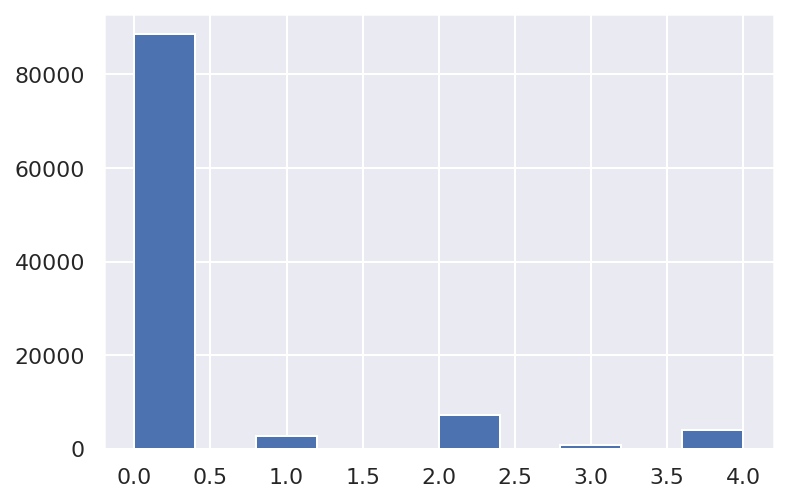

In [12]:
plt.hist(y)

<AxesSubplot:ylabel='Count'>

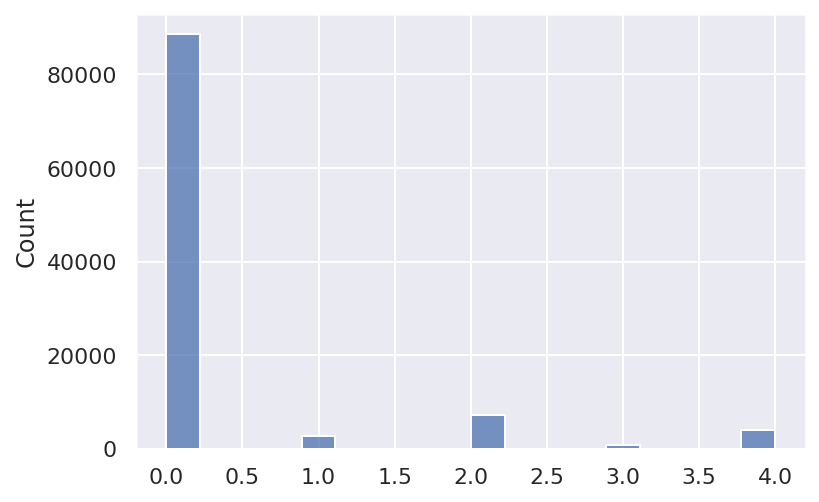

In [13]:
sns.histplot(y)

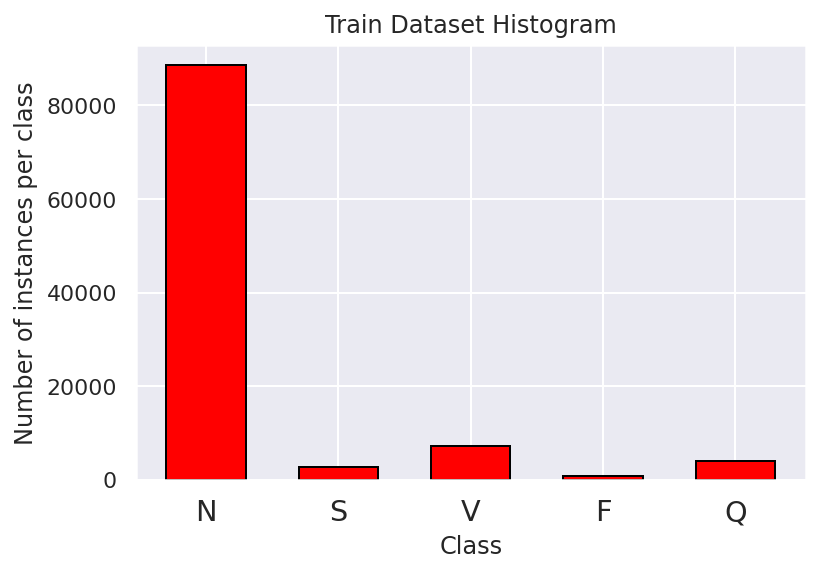

In [14]:
plt.hist(y, bins=5, edgecolor='black', rwidth =0.6, label=classes, color='red')
plt.title("Train Dataset Histogram")
plt.xlabel("Class")
plt.ylabel("Number of instances per class")
plt.xticks([0.4, 1.2, 2, 2.8, 3.6], classes, size='large')
plt.show()

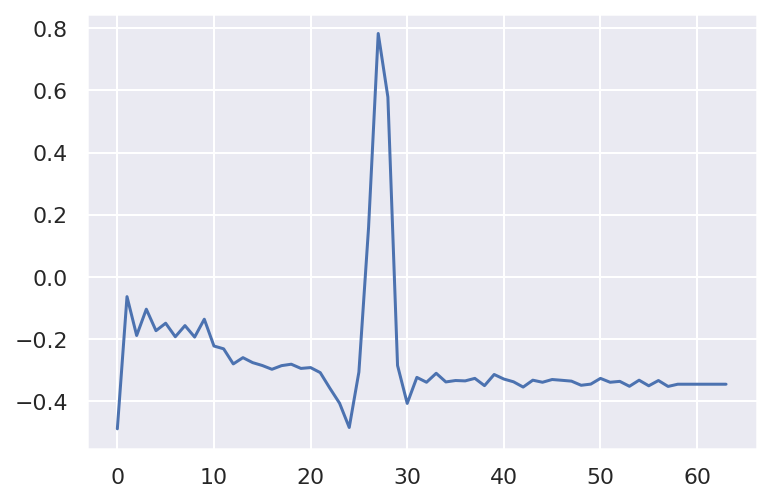

In [15]:
plt.plot(X[0])

In [16]:
N_loc = 10
N_glob = 80
N_avg = 400

In [17]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    Temp2 = (cumsum[N:] - cumsum[:-N]) / float(N)
    Temp1 = np.copy(x[:N-1].astype('float32'))
    for i,elem in enumerate(Temp1):
        Temp1[i] = np.mean(x[:i+1])
    Temp = np.concatenate((Temp1,Temp2),axis=0)
    return Temp

In [18]:
T_loc = np.copy(T[:,0])
for record in np.unique(data_set_np[:,-3]):
    Temp = T_loc[np.where(data_set_np[:,-3] == record)]
    T_loc[np.where(data_set_np[:,-3] == record)] = running_mean(Temp, N_loc)

T_glob = np.copy(T[:,0])
for record in np.unique(data_set_np[:,-3]):
    Temp = T_loc[np.where(data_set_np[:,-3] == record)]
    T_loc[np.where(data_set_np[:,-3] == record)] = running_mean(Temp, N_glob)

T_avg = np.copy(T[:,0])
for record in np.unique(data_set_np[:,-3]):
    Temp = T_loc[np.where(data_set_np[:,-3] == record)]
    T_loc[np.where(data_set_np[:,-3] == record)] = running_mean(Temp, N_avg)

In [19]:
T_nor = np.concatenate((np.expand_dims(T[:,0]/T_glob,axis=-1),
                       np.expand_dims(T[:,1]/T_glob,axis=-1),
                       np.expand_dims(T[:,0]/T_avg,axis=-1),
                       np.expand_dims(T[:,1]/T_avg,axis=-1)), axis=1)
if Nor_T:
    T = T_nor

In [20]:
X_diff = np.diff(X)
X_diff = np.append(X,np.zeros((X.shape[0],1)),axis=1)
if diff:
    X = X_diff

In [21]:
X, X_tst, T, T_tst, y, y_tst = train_test_split(X, T, y, test_size=0.2,stratify=y, random_state=42)

In [22]:
X_trn, X_val, T_trn, T_val, y_trn, y_val = train_test_split(X, T, y, test_size=0.2,stratify=y, random_state=42)

In [23]:
y_oh = to_categorical(y)
y_trn_oh = to_categorical(y_trn)
y_tst_oh = to_categorical(y_tst)
y_val_oh = to_categorical(y_val)

X_tf = np.expand_dims(X, axis=2)
X_trn_tf = np.expand_dims(X_trn, axis=2)
X_tst_tf = np.expand_dims(X_tst, axis=2)
X_val_tf = np.expand_dims(X_val, axis=2)

T_tf = np.expand_dims(T, axis=2)
T_trn_tf = np.expand_dims(T_trn, axis=2)
T_tst_tf = np.expand_dims(T_tst, axis=2)
T_val_tf = np.expand_dims(T_val, axis=2)

In [24]:
from sklearn.utils import class_weight
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(y_trn), y_trn)))
class_weights

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.23308923435266715,
 1: 7.45451467268623,
 2: 2.871608695652174,
 3: 25.85009784735812,
 4: 5.298596068993181}

# Design Filters

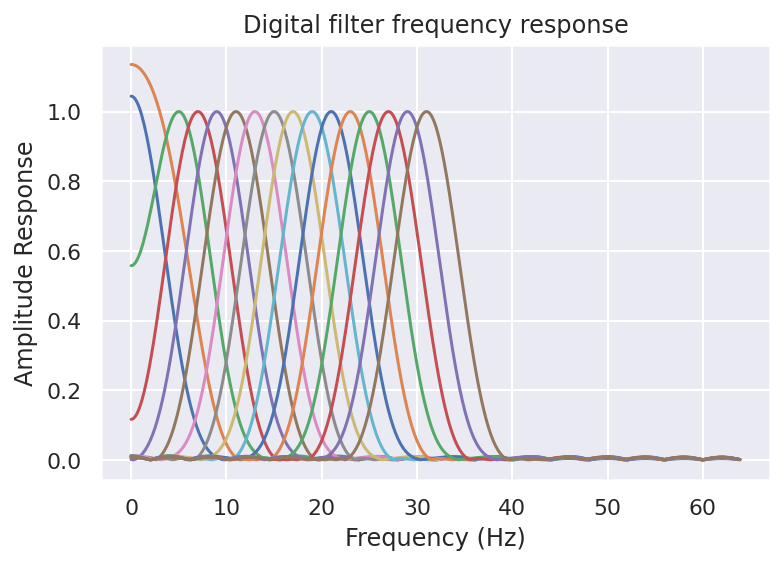

In [25]:
conv1d_filters = 16
conv1d_kernel = 32
bw = fs/(4*conv1d_filters)

from scipy.signal import firwin, freqz
w = np.ndarray(shape=(conv1d_filters,conv1d_kernel))
b = np.zeros(shape=(conv1d_filters))
for i in range(conv1d_filters):
    w[i] = firwin(conv1d_kernel, [bw*i+0.01, bw*(i+1)-0.01], pass_zero=False,fs=fs)
    f, a = freqz(w[i])
    plt.plot((f/np.pi)*fs/2, np.abs(a))

plt.title('Digital filter frequency response')
plt.ylabel('Amplitude Response')
plt.xlabel('Frequency (Hz)')
plt.show()

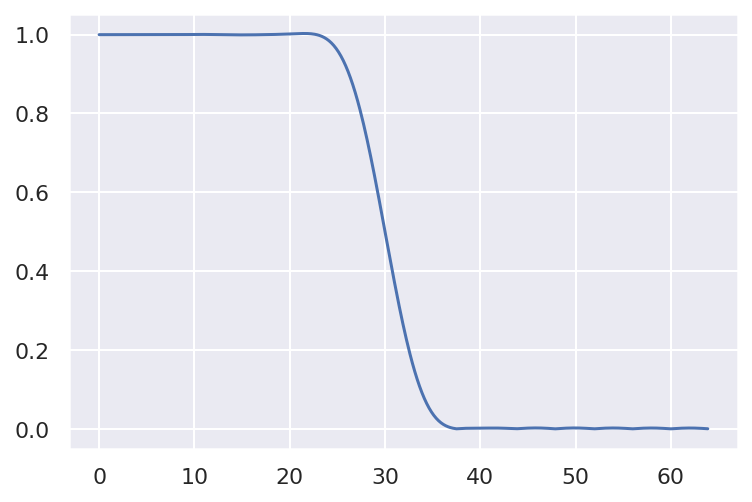

In [26]:
#noise removal Filter
w_n = firwin(conv1d_kernel, [30], pass_zero=True,fs=fs)
f, a = freqz(w_n)
plt.plot((f/np.pi)*fs/2, np.abs(a))

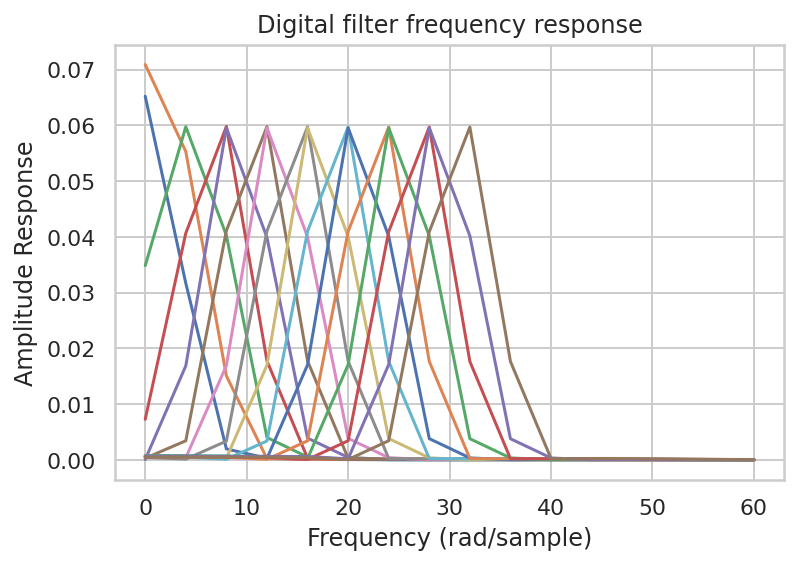

In [27]:
N = conv1d_kernel
F = conv1d_filters

sns.set_style("whitegrid")

for i in range(F):
    x = w[i]
    x_f = fft(x)
    f=fftfreq(N, 1/fs)[:N//2]
    plt.plot(f, 2.0/N * np.abs(x_f[0:N//2]))

plt.title('Digital filter frequency response')
plt.ylabel('Amplitude Response')
plt.xlabel('Frequency (rad/sample)')
plt.show()

In [38]:
conv2d_filters = 32
conv2d_kernel = 4
T_dense_nodes = 32
pool_size=2
kernel_weights = np.transpose(w).reshape((conv1d_kernel,1,conv1d_filters))
noise_kernel_weights = np.transpose(w_n).reshape((conv1d_kernel,1,1))

def build_model():

    inp1 = Input(shape=X_trn_tf[1,:].shape, name="Signal_Layer")
    inp2 = Input(shape=T_trn_tf[1,:].shape, name="Period_Layer")

#Interval Pipeline
    T = Dense(T_dense_nodes, activation='relu', name = 'Dense_T1')(inp2)  
    T = Dense(T_dense_nodes//2, activation='relu', name = 'Dense_T2')(T)
    T = Dense(T_dense_nodes//4, activation='relu', name = 'Dense_T3')(T)

    T = Flatten()(T)

# Noise Removal FIR filter
    x = Conv1D(1, conv1d_kernel, padding='same', name="Conv1DLayer_0",trainable=False, use_bias=False)(inp1)
    x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    x = Conv1D(conv1d_filters, conv1d_kernel, padding='same', name="Conv1DLayer_1",trainable=False, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

#Conv2D Pipeline    
    x = Reshape((X_trn_tf.shape[1], -1,1))(x)

    x = Conv2D(conv2d_filters, conv2d_kernel, padding="same", name="Conv2DLayer_1")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size, padding='same')(x)

    x = SeparableConv2D(conv2d_filters*pool_size, conv2d_kernel, padding="same", name="Conv2DLayer_2")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size, padding='same')(x)

    x = SeparableConv2D(conv2d_filters*pool_size**2,conv2d_kernel, padding="same", name="Conv2DLayer_f")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalMaxPooling2D()(x)

    x = Flatten()(x)
    x = concatenate([x,T])
    
    x = Dense(num_classes, activation='softmax', name = 'OuputLayer')(x)
    
    model = Model(inputs=[inp1, inp2], outputs=[x])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                                 decay_steps=1024,decay_rate=0.8)

    opt = Adam(learning_rate=lr_schedule)
    #loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2) 
    loss = 'categorical_crossentropy'

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy',
                                                     keras.metrics.AUC(),
                                                     tfa.metrics.F1Score(num_classes=5, average='macro'),
                                                     keras.metrics.Recall()])

    return model

model = build_model()
model.get_layer('Conv1DLayer_1').set_weights([kernel_weights])
model.get_layer('Conv1DLayer_1').trainable = False
model.get_layer('Conv1DLayer_0').set_weights([noise_kernel_weights])

In [39]:
epochs = 500
batch_size = 512

callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='./models/best_model.h5',
                             monitor='val_f1_score', mode='max', save_best_only=True)]
start = time.time()

history=model.fit((X_trn_tf, T_trn_tf) , y_trn_oh, epochs=epochs,callbacks=callbacks,# shuffle=True,
                  class_weight = class_weights,# sample_weight=sample_weights,
                  batch_size=batch_size,validation_data = ([X_val_tf,T_val_tf],y_val_oh))
end = time.time()

#model.fit((X_tf, T_tf) , y_oh, epochs=epochs,callbacks=callbacks,# shuffle=True,
#                  class_weight = class_weights,# sample_weight=sample_weights,
#                  batch_size=batch_size,validation_split=0.2)

training_time = end - start

print('Training time is',training_time)

model.load_weights('./models/best_model.h5')

Epoch 1/500
129/129 [==============================] - 7s 40ms/step - loss: 0.8283 - accuracy: 0.7099 - auc_2: 0.9168 - f1_score: 0.5133 - recall_2: 0.6442 - val_loss: 0.5468 - val_accuracy: 0.9028 - val_auc_2: 0.9606 - val_f1_score: 0.3680 - val_recall_2: 0.8748
Epoch 2/500
129/129 [==============================] - 5s 37ms/step - loss: 0.3482 - accuracy: 0.8477 - auc_2: 0.9759 - f1_score: 0.6532 - recall_2: 0.8190 - val_loss: 0.4805 - val_accuracy: 0.8032 - val_auc_2: 0.9687 - val_f1_score: 0.4068 - val_recall_2: 0.7869
Epoch 3/500
129/129 [==============================] - 5s 35ms/step - loss: 0.3255 - accuracy: 0.8582 - auc_2: 0.9782 - f1_score: 0.6615 - recall_2: 0.8386 - val_loss: 0.1067 - val_accuracy: 0.9681 - val_auc_2: 0.9973 - val_f1_score: 0.8472 - val_recall_2: 0.9671
Epoch 4/500
129/129 [==============================] - 4s 31ms/step - loss: 0.3075 - accuracy: 0.8584 - auc_2: 0.9777 - f1_score: 0.6653 - recall_2: 0.8422 - val_loss: 0.3438 - val_accuracy: 0.8846 - val_auc_

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Signal_Layer (InputLayer)      [(None, 64, 1)]      0           []                               
                                                                                                  
 Conv1DLayer_0 (Conv1D)         (None, 64, 1)        32          ['Signal_Layer[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 64, 1)       4           ['Conv1DLayer_0[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 Conv1DLayer_1 (Conv1D)         (None, 64, 16)       512         ['batch_normalization_10[0]

In [41]:
model_size = os.stat('./models/best_model.h5').st_size
trn_mem=tf.config.experimental.get_memory_usage("GPU:0")

2064/2064 [==============================] - 30s 15ms/step - loss: 9.7120e-04 - accuracy: 1.0000 - auc_2: 1.0000 - f1_score: 0.9997 - recall_2: 1.0000
Train loss: 0.0009711987222544849, Train accuracy: 0.9999697208404541
645/645 [==============================] - 7s 9ms/step - loss: 0.0484 - accuracy: 0.9891 - auc_2: 0.9981 - f1_score: 0.9323 - recall_2: 0.9891
Test loss: 0.048408616334199905, Test accuracy: 0.9891473054885864


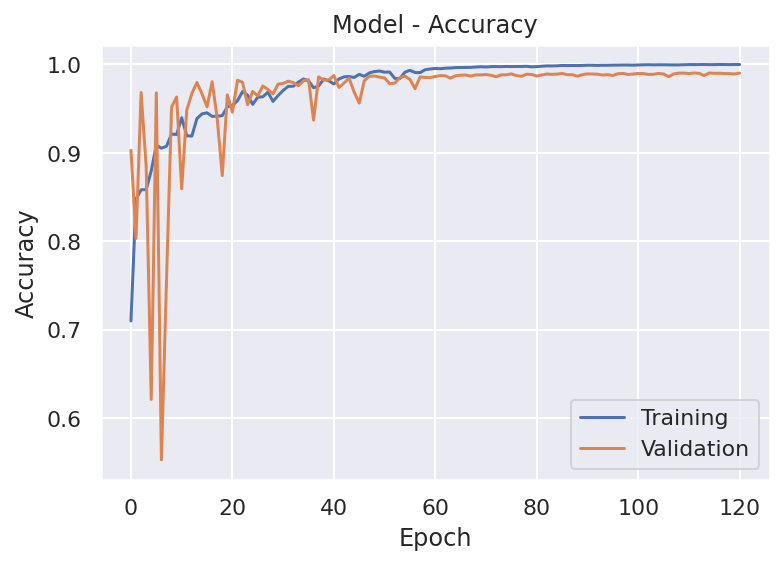

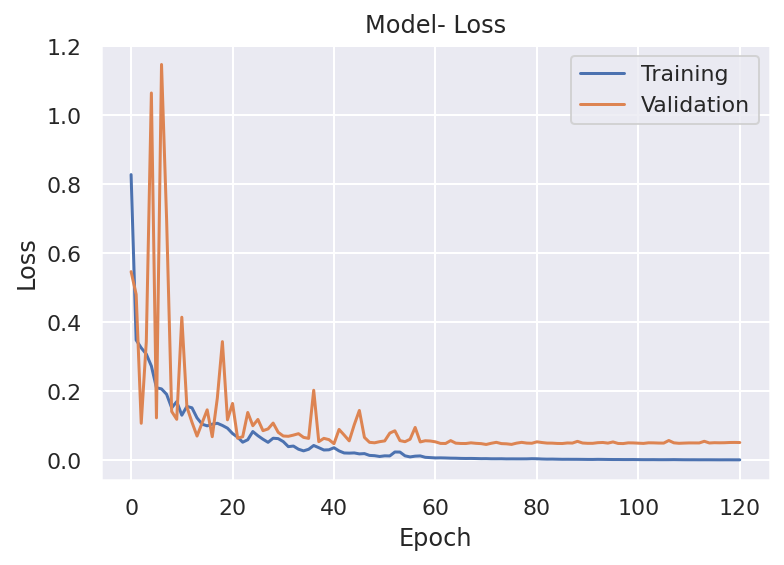

Confusion matrix, without normalization


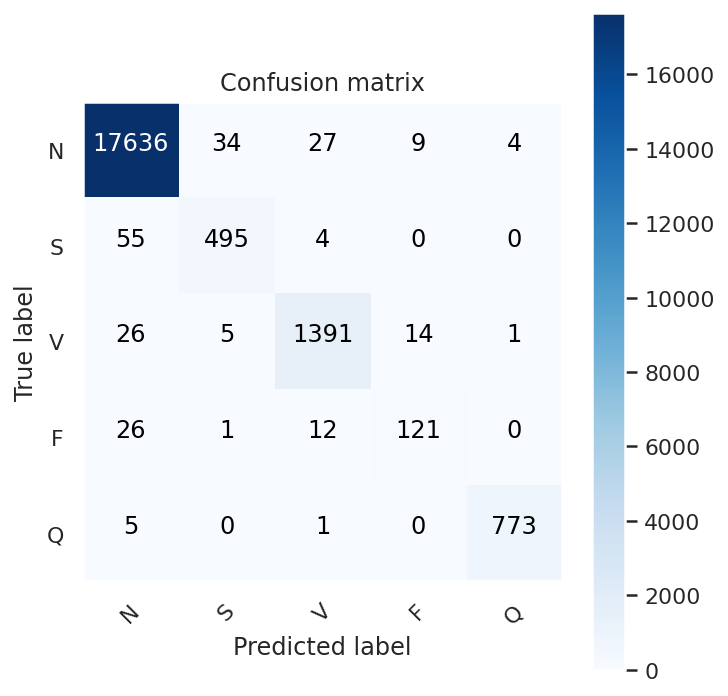

accuracy score =  0.9891472868217054
recall score =  0.9211720116392398
f1 score =  0.9322991964494609
auc score =  0.996720525066975
              precision    recall  f1-score   support

           0     0.9937    0.9958    0.9948     17710
           1     0.9252    0.8935    0.9091       554
           2     0.9693    0.9680    0.9687      1437
           3     0.8403    0.7562    0.7961       160
           4     0.9936    0.9923    0.9929       779

    accuracy                         0.9891     20640
   macro avg     0.9444    0.9212    0.9323     20640
weighted avg     0.9890    0.9891    0.9890     20640

[[17636    34    27     9     4]
 [   55   495     4     0     0]
 [   26     5  1391    14     1]
 [   26     1    12   121     0]
 [    5     0     1     0   773]]
CPU times: user 29.9 s, sys: 5.08 s, total: 34.9 s
Wall time: 44.1 s


In [42]:
%%time
scores = evaluate_model(model,history)

In [35]:
with tf.device('/cpu:0'):
    start = time.time()
    model.predict((X_tst_tf,T_tst_tf))
    end = time.time()

cpu_inference_time =  (end-start)/X_tst_tf.shape[0]
cpu_throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on CPU is :", cpu_inference_time)
print("Throughput on CPU is :", cpu_throughput, "sequence per second")

Inference on CPU is : 0.00040598031162291536
Throughput on CPU is : 2463.1736352003813 sequence per second


In [36]:
with tf.device('/gpu:0'):
    start = time.time()
    model.predict((X_tst_tf,T_tst_tf))
    end = time.time()

gpu_inference_time =  (end-start)/X_tst_tf.shape[0]
gpu_throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on GPU is :", gpu_inference_time)
print("Throughput on GPU is :", gpu_throughput, "sequence per second")

Inference on GPU is : 9.788971307665802e-05
Throughput on GPU is : 10215.578006821757 sequence per second


[Text(0.5, 1.0, 'MIT-BIH Test Dataset T-SNE projection')]

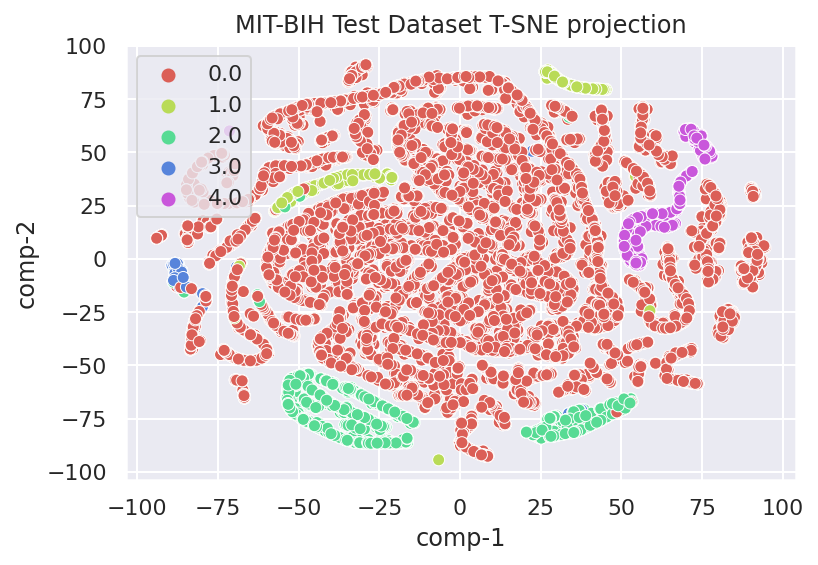

In [35]:
from sklearn.manifold import TSNE 
 
X_tst_compressed = model.predict((X_tst_tf,T_tst_tf)) 
tsne = TSNE() 
X_tst_2D = tsne.fit_transform(X_tst_compressed)

df = pd.DataFrame()
df["y"] = y_tst
df["comp-1"] = X_tst_2D[:,0]
df["comp-2"] = X_tst_2D[:,1]

sns.set_style("darkgrid")
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5), 
                data=df).set(title="MIT-BIH Test Dataset T-SNE projection") 

Accuracy: 0.9913953488372093


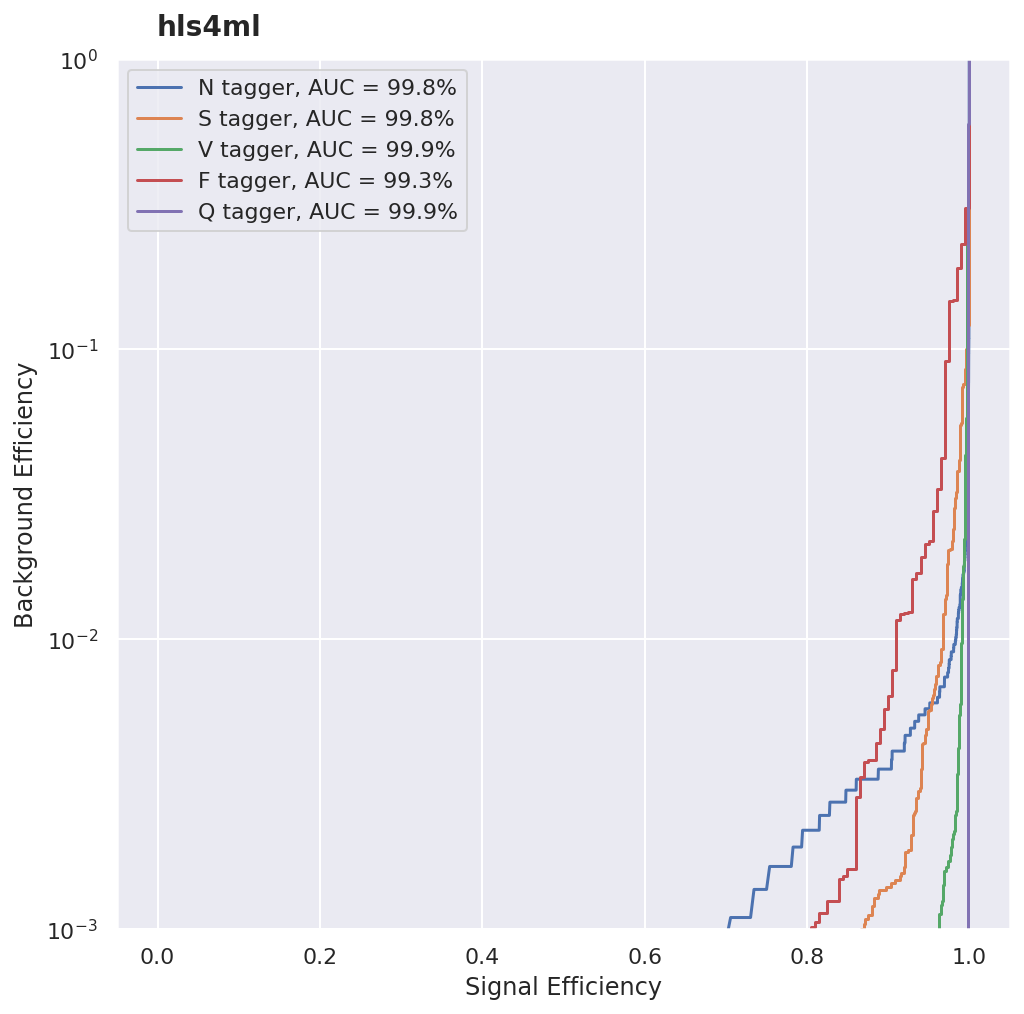

In [36]:
import plotting

y_keras = model.predict((X_tst_tf,T_tst_tf))
print("Accuracy: {}".format(accuracy_score(np.argmax(y_tst_oh, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(8,8))
_ = plotting.makeRoc(y_tst_oh, y_keras, classes)

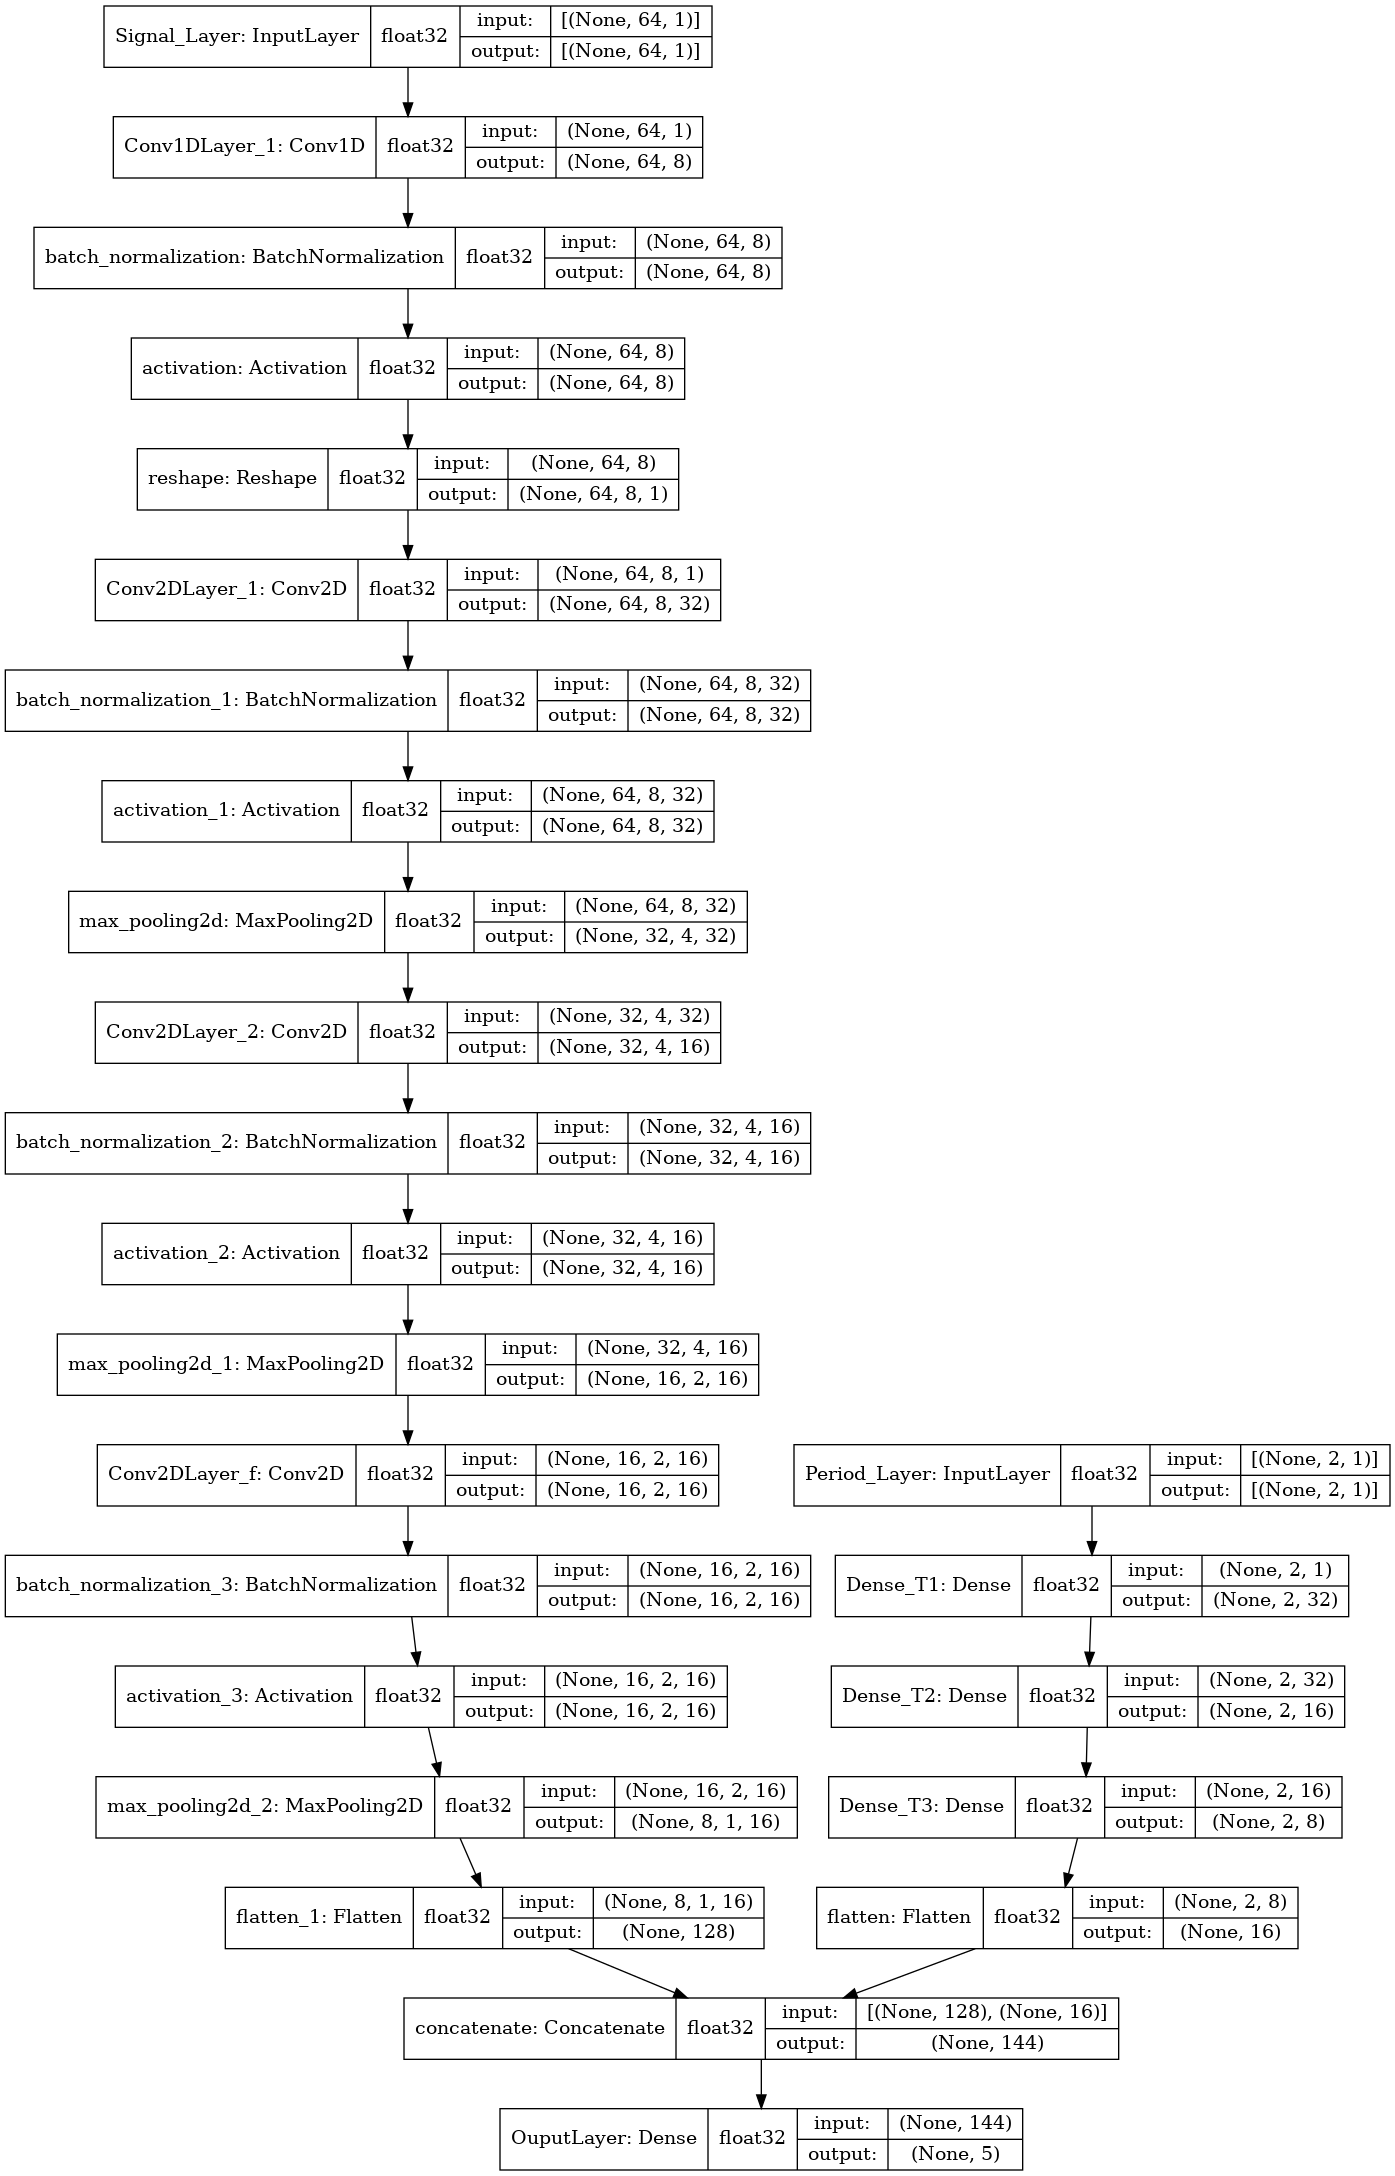

In [37]:
from keras.utils import plot_model
plot_model(model,show_shapes=True, show_dtype=True)
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [38]:
try:
    from plot_model import plot_model
    plot_model(model,to_file='`./models/base_model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)
except Exception as ex:
    print(ex)

No module named 'plot_model'


In [39]:
## Update results
results_dict['model_name'].append('keras base model')
results_dict['no_par'].append(model.count_params())
results_dict['trn_t'].append(training_time)
results_dict['trn_mem'].append(trn_mem)
results_dict['trn_acc'].append(scores[0])
results_dict['tst_acc'].append(scores[1])
results_dict['recall_scr'].append(scores[2])
results_dict['f1_scr'].append(scores[3])
results_dict['auc_scr'].append(scores[4])
results_dict['cpu_inf_t'].append(cpu_inference_time)
results_dict['cpu_thrpt'].append(cpu_throughput)
results_dict['gpu_inf_t'].append(gpu_inference_time)
results_dict['gpu_thrpt'].append(gpu_throughput)
results_dict['model_size'].append(model_size)
results_dict['gzipped_size'].append(get_gzipped_model_size(model))

# Visualization in Time and Frequency Domains

In [40]:
model = keras.models.load_model('./models/best_model.h5')

In [41]:
filters_dict = {}
for layer in model.layers:
# check for convolutional layer
    if 'Conv1DLayer' not in layer.name:
        continue
        # get filter weights
    filters, biases = layer.get_weights()
    #f_min, f_max = filters.min(), filters.max()
    #filters = (filters - f_min) / (f_max - f_min)
    print(layer.name, filters.shape)
    filters_dict[layer.name] = filters

Conv1DLayer_1 (16, 1, 8)


In [42]:
filters_dict.keys()

dict_keys(['Conv1DLayer_1'])

In [43]:
filt = filters_dict['Conv1DLayer_1']

In [44]:
filt.shape

(16, 1, 8)

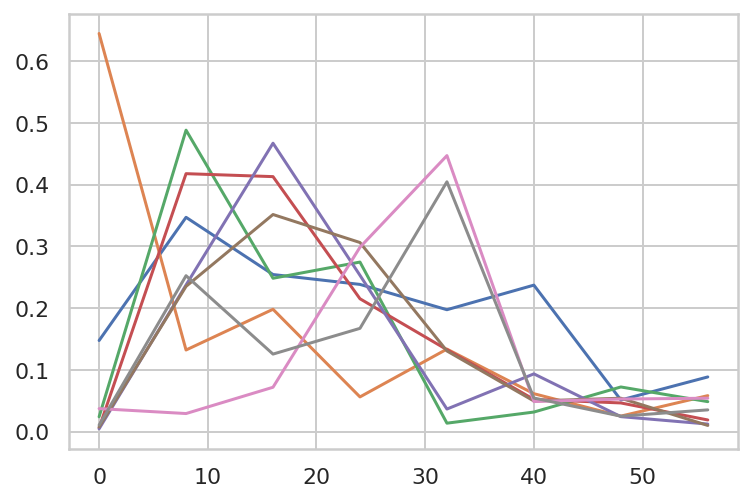

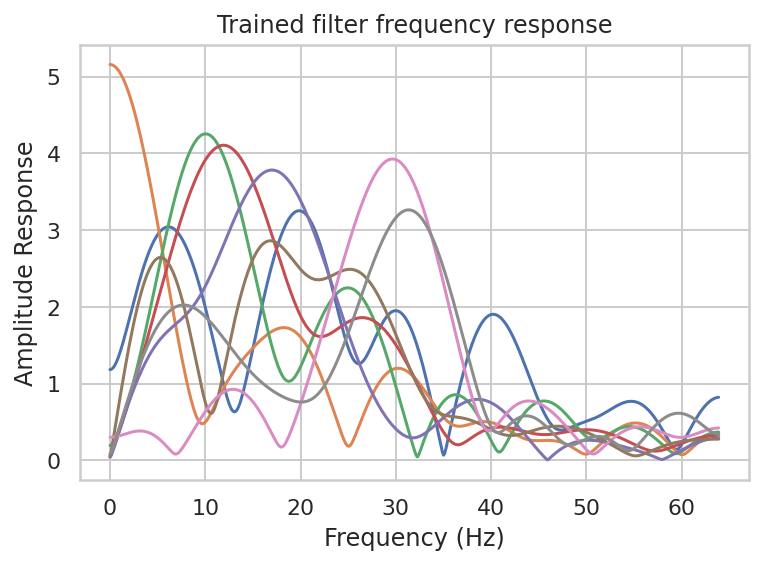

In [45]:
fs=128
N = filt.shape[0]
F = filt.shape[2]
t = np.arange(N)*1/fs

sns.set_style("whitegrid")

for i in range(F):
    x = filt[:,:,i].reshape(-1)
    x_f = fft(x)
    f=fftfreq(N, 1/fs)[:N//2]
    plt.plot(f, 2.0/N * np.abs(x_f[0:N//2]))
plt.show()

for i in range(F):
    x = filt[:,:,i].reshape(-1)
    f, a = freqz(x)
    plt.plot((f/np.pi)*fs/2, np.abs(a))
    
plt.title('Trained filter frequency response')
plt.ylabel('Amplitude Response')
plt.xlabel('Frequency (Hz)')
plt.show()

In [46]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    ax.plot(xmax, ymax, 'ro')
    text= "$f$={:.2f} Hz, $\|X(f)\|$={:.2f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color='red', linewidth=2, mutation_scale=20)
    kw = dict(xycoords='data',textcoords="axes fraction", arrowprops=arrowprops, ha="right", va="top", fontsize=11)
              # bbox=bbox_props, 
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    

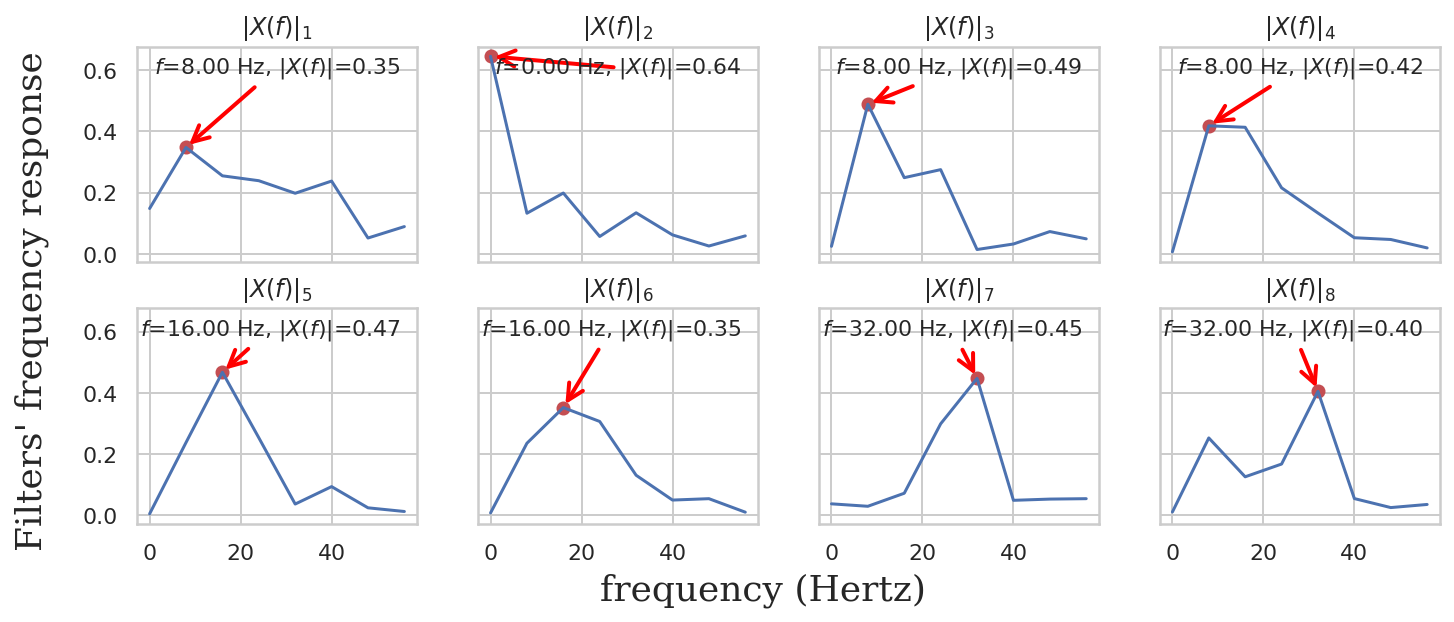

In [47]:
from scipy.fft import fft, fftfreq
fs=128

t = np.arange(N)*1/fs
N = filt.shape[0] # Filter size
F = filt.shape[2] # number of filters

f=fftfreq(N, 1/fs)[:N//2]

sns.set_style("whitegrid")

c = 4
r = F//4

fig, axes = plt.subplots(r, c, sharex=True, sharey=True, figsize=(10,4))
fig.text(0.5, -0.02, 'frequency (Hertz)', ha='center', fontfamily = 'serif', fontsize = 18)
fig.text(-0.02, 0.5, 'Filters\' frequency response', va='center', rotation='vertical',fontfamily = 'serif', fontsize = 18)

#fig = plt.figure(figsize=(12,6))
plt.tight_layout()
#fig.subplots_adjust(hspace=0.2, wspace=0.4)

for i in range(F):
    x = filt[:,:,i].reshape(-1)
    x_f = 2.0/N * np.abs(fft(x)[0:N//2])
    annot_max(f,x_f,axes[i//4,i%4])
    #plt.subplot(r,c,i+1)
    axes[i//4,i%4].set_title(f'$\|X(f)\|_{{{i+1}}}$')
    axes[i//4,i%4].plot(f, x_f)

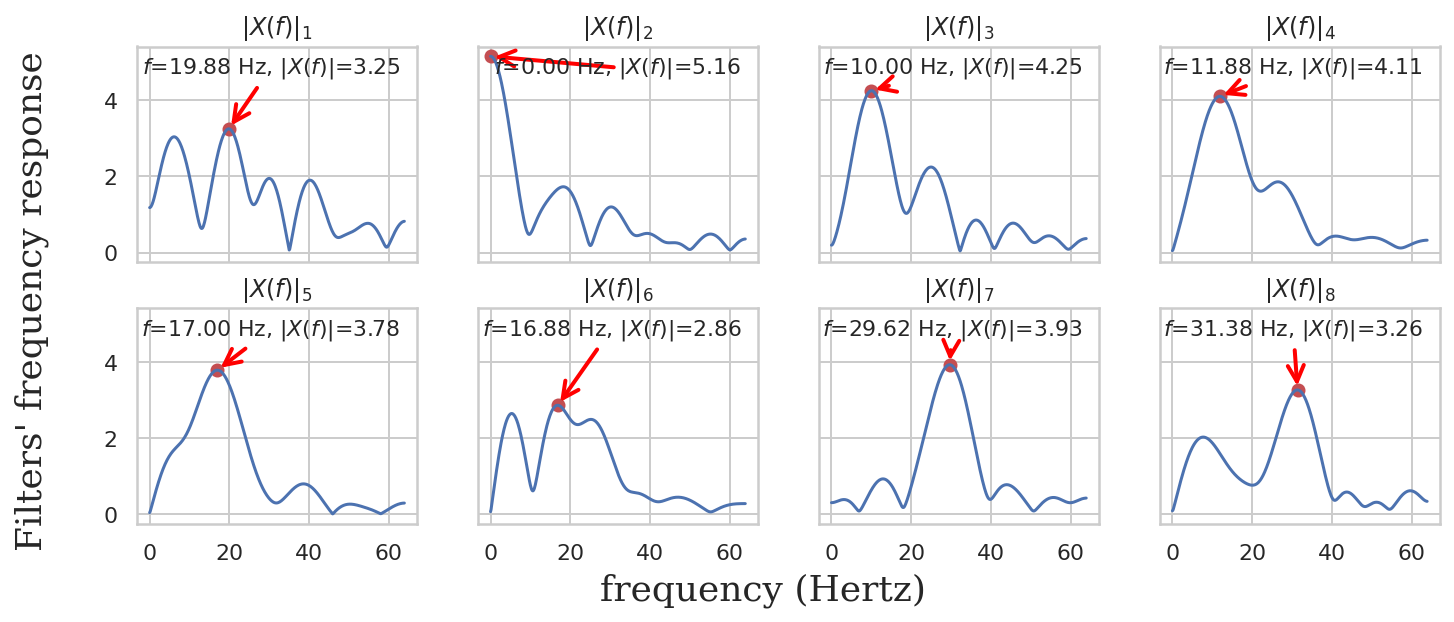

In [48]:
from scipy.fft import fft, fftfreq
fs=128

t = np.arange(N)*1/fs
N = filt.shape[0] # Filter size
F = filt.shape[2] # number of filters

f=fftfreq(N, 1/fs)[:N//2]

sns.set_style("whitegrid")

c = 4
r = F//4

fig, axes = plt.subplots(r, c, sharex=True, sharey=True, figsize=(10,4))
fig.text(0.5, -0.02, 'frequency (Hertz)', ha='center', fontfamily = 'serif', fontsize = 18)
fig.text(-0.02, 0.5, 'Filters\' frequency response', va='center', rotation='vertical',fontfamily = 'serif', fontsize = 18)

#fig = plt.figure(figsize=(12,6))
plt.tight_layout()
#fig.subplots_adjust(hspace=0.2, wspace=0.4)

for i in range(F):
    x = filt[:,:,i].reshape(-1)
    f, a = freqz(x)
    f = (f/np.pi)*fs/2
    annot_max(f,np.abs(a),axes[i//4,i%4])
    #plt.subplot(r,c,i+1)
    axes[i//4,i%4].set_title(f'$\|X(f)\|_{{{i+1}}}$')
    axes[i//4,i%4].plot(f, np.abs(a))


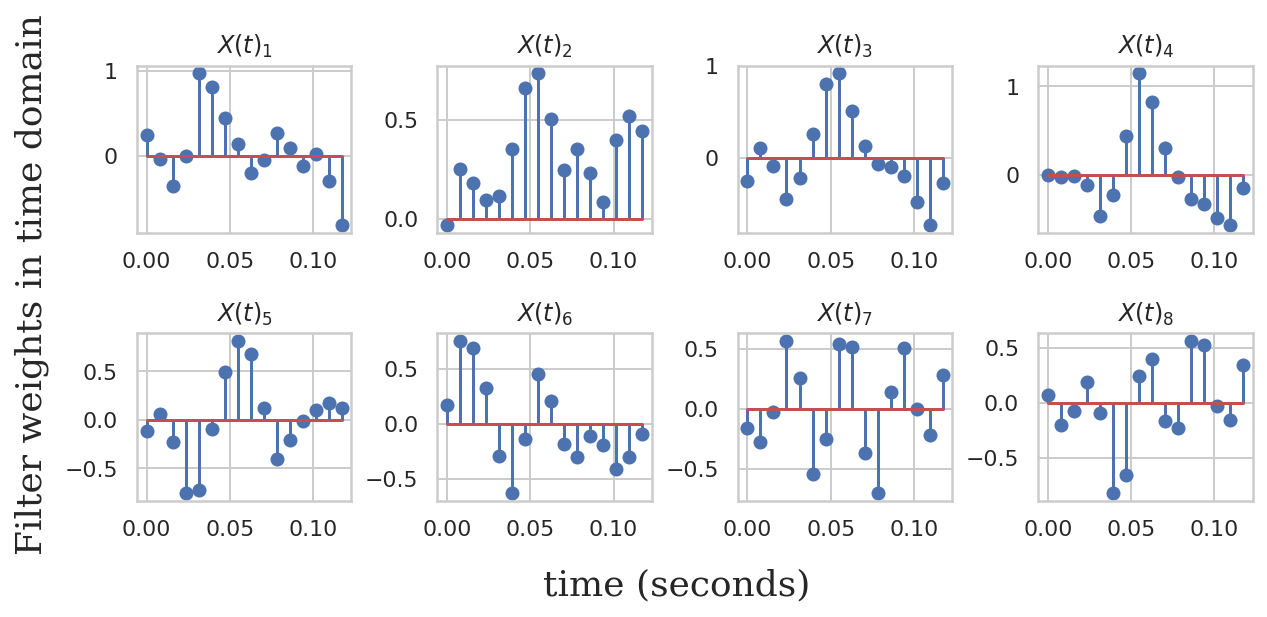

In [49]:
fig, axes = plt.subplots(r, c, sharex=True, sharey=True, figsize=(10,4))
    
fig.subplots_adjust(hspace=0.6, wspace=0.4)

fig.text(0.5, -0.04, 'time (seconds)', ha='center', fontfamily = 'serif', fontsize = 18)
fig.text(0.04, 0.5, 'Filter weights in time domain', va='center', rotation='vertical',fontfamily = 'serif', fontsize = 18)

for i in range(F):
    x = filt[:,:,i].reshape(-1)
    plt.subplot(r,c,i+1)
    plt.title(f'$X(t)_{{{i+1}}}$')
    plt.stem(t, x)

# Visualize Activations

In [50]:
pred_prob = model.predict((X_tst_tf,T_tst_tf))
y_pred = np.argmax(pred_prob,axis=1)

In [51]:
layer_outputs = [layer.output for layer in model.layers] 
# Extracts the outputs of layer 2 (Activations of Conv1D)
activation_model = Model(inputs=model.input, outputs=[layer_outputs[1], layer_outputs[3]]) 

# Get the activations of Layer 2 Conv1D
Conv1D_Outputs = activation_model.predict((X_tst_tf,T_tst_tf))[0]
Conv1D_Activations = activation_model.predict((X_tst_tf,T_tst_tf))[1]

In [52]:
Conv1D_Activations.shape

(25800, 64, 8)

In [53]:
#create array for indices, activations, and hit/miss for each class
cls_data = {}
for cls in range(num_classes):
    cls_data[cls] = {'class_indices':[],
                       'Conv1D_Outputs': [],
                       'Conv1D_Activations': [],
                       'hit_miss': [],
                       'y_pred':[],
                       'pred_prob': []
                      }
    indices = np.where(y_tst==cls)
    cls_data[cls]['class_indices'] = np.asarray(indices).reshape(-1,)
    cls_data[cls]['Conv1D_Outputs'] = Conv1D_Outputs[indices]
    cls_data[cls]['Conv1D_Activations'] = Conv1D_Activations[indices]
    cls_data[cls]['hit'] =  y_pred[indices]==y_tst[indices]
    cls_data[cls]['y_pred'] =  y_pred[indices]
    cls_data[cls]['pred_prob'] =  pred_prob[indices]

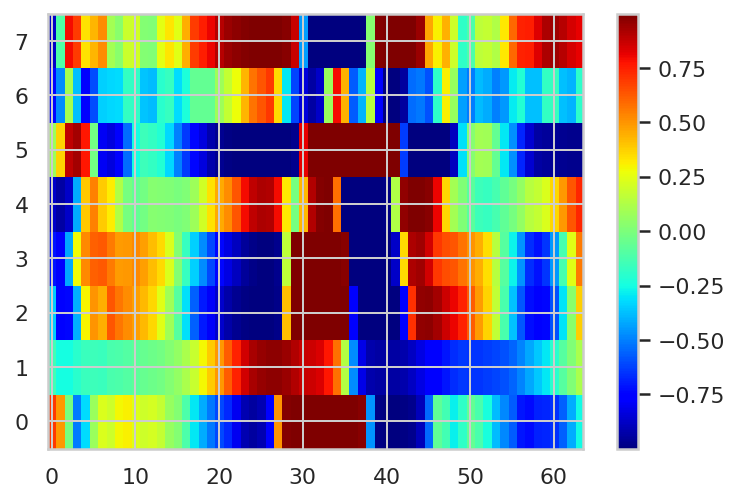

In [54]:
#Example: Plot the activatons of Conv1D_0 Layer for instance 0 of class 2
plt.imshow(cls_data[2]['Conv1D_Activations'][0].transpose(),cmap='jet',aspect='auto',origin='lower')
plt.colorbar()

# Visualize Signal STFT

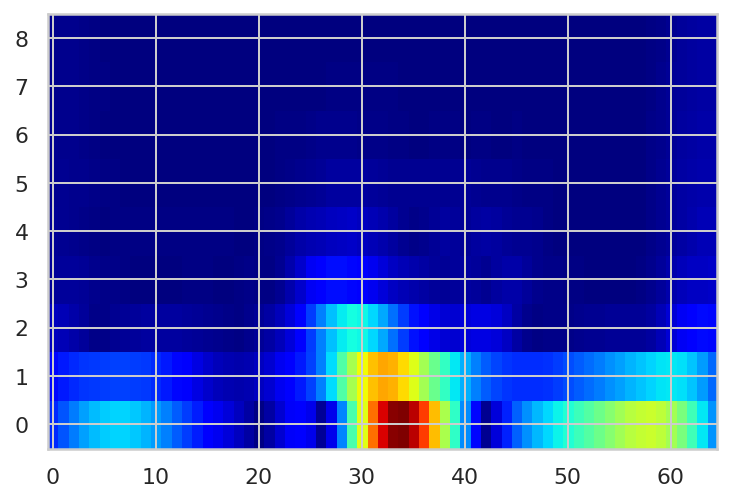

In [55]:
#Example: Plot the signal STFT of instance 0 of class 2
signal = X_tst_tf[cls_data[2]['class_indices'][1]].reshape(-1)
spectrogram = np.abs(stft(signal,fs=fs, nperseg=16, noverlap=15, nfft=16, padded=True)[2])
plt.imshow(spectrogram,cmap='jet',aspect='auto',origin='lower')

# Plot time, frequency, STFT, and activations of a random True samples

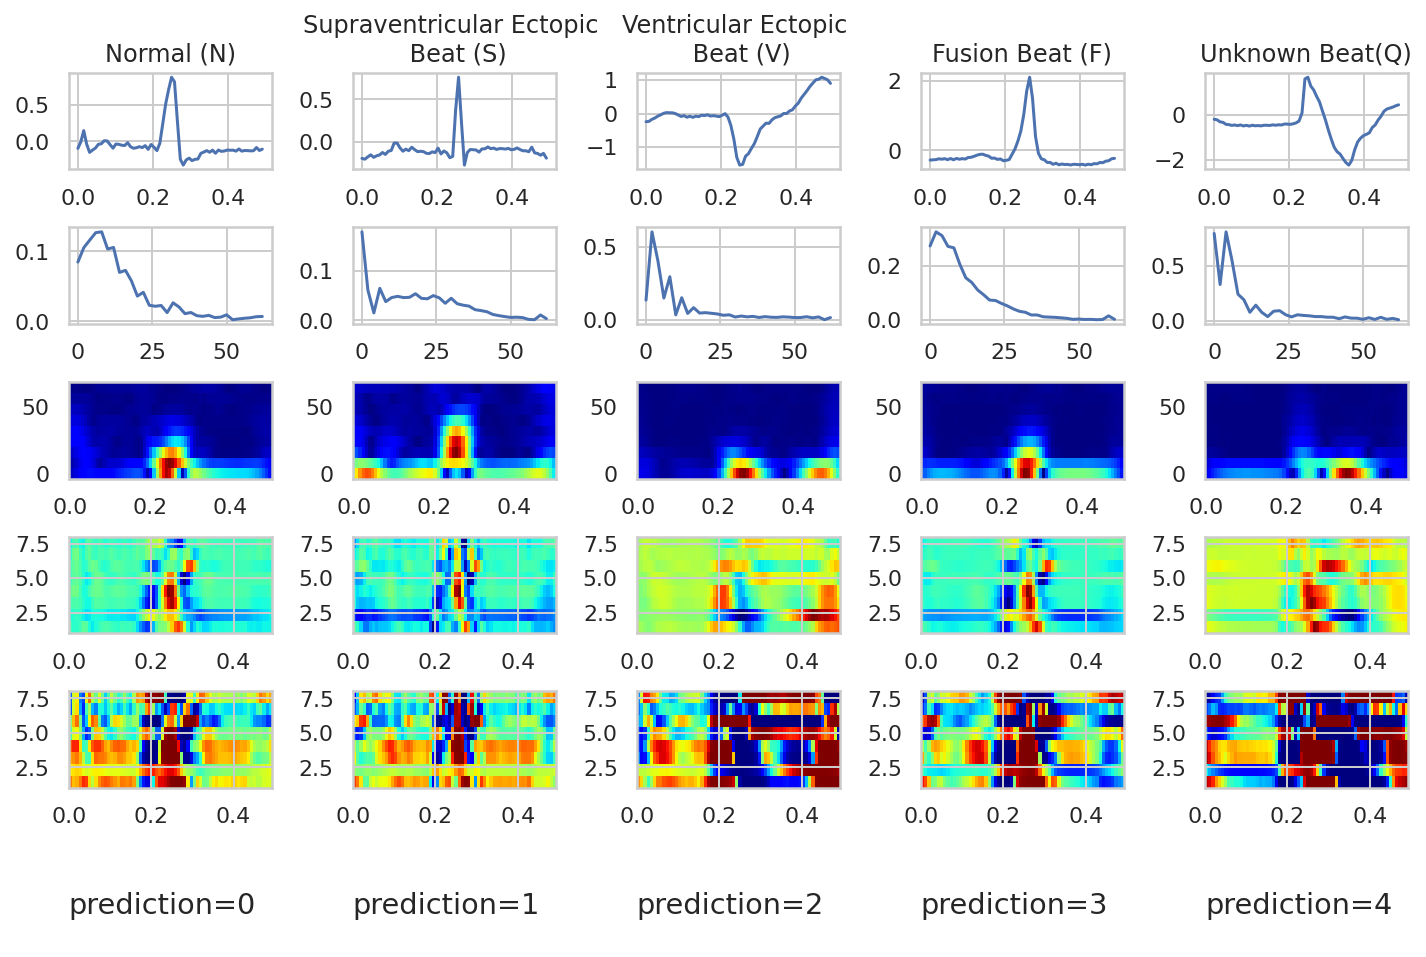

In [56]:
from random import seed
from random import randint

seed(40)

fig, axes = plt.subplots(6, 5, figsize=(12,8))
    
#fig = plt.figure(figsize=(12,6))
#plt.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.4)

N = X_tst_tf.shape[1]
t = np.arange(N)*1/fs
f=fftfreq(N, 1/fs)[:N//2]

col = ['Normal (N)', 'Supraventricular Ectopic \n Beat (S)', 'Ventricular Ectopic \n Beat (V)', 'Fusion Beat (F)', 'Unknown Beat(Q)']

for ax, col in zip(axes[0], col):
    ax.set_title(col)


for i in range(num_classes):
    random_instance = randint(0,10)
    class_index = np.where(cls_data[i]['hit']==True)[0][random_instance] ## Set True
    signal = X_tst_tf[cls_data[i]['class_indices'][class_index]].reshape(-1) 
    axes[0, i].plot(t, signal)
    x_f = 2.0/N * np.abs(fft(signal)[0:N//2])
    axes[1, i].plot(f,x_f)
    f2, t2, spectrogram = stft(signal, fs=fs, nperseg=16, noverlap=15, nfft=16, padded=True)
    #spectrogram = np.abs(stft(signal, fs=fs, nperseg=16, noverlap=15, nfft=16, padded=True)[2])
    #axes[2,i].imshow(spectrogram,cmap='jet',aspect='auto',origin='lower')
    axes[2,i].pcolormesh(t2,f2,np.abs(spectrogram),cmap='jet',shading='auto')
    axes[3,i].imshow(cls_data[i]['Conv1D_Outputs'][class_index].transpose(),
                     extent=[min(t),max(t),1,conv1d_filters],
                     cmap='jet',aspect='auto',origin='lower')
    axes[4,i].imshow(cls_data[i]['Conv1D_Activations'][class_index].transpose(),
                     extent=[min(t),max(t),1,conv1d_filters],
                     cmap='jet',aspect='auto',origin='lower')
    #axes[5,i].text(0,0.7,np.array2string(pred_prob[cls_data[i]['class_indices'][class_index]], 
    #                                       precision=2, separator=',',suppress_small=True),size='large')
    axes[5,i].text(0,0.3,"prediction=" + np.array2string(y_pred[cls_data[i]['class_indices'][class_index]], 
                                                           precision=2, separator=',',suppress_small=True),size='large')
    axes[5,i].axis('off')
    #axes[3,i].pcolormesh(t,np.arange(16),cls_data[i]['activations'][class_index],cmap='jet', shading='auto')

# Plot time, frequency, STFT, and activations of a random False samples

IndexError: index 3 is out of bounds for axis 0 with size 3

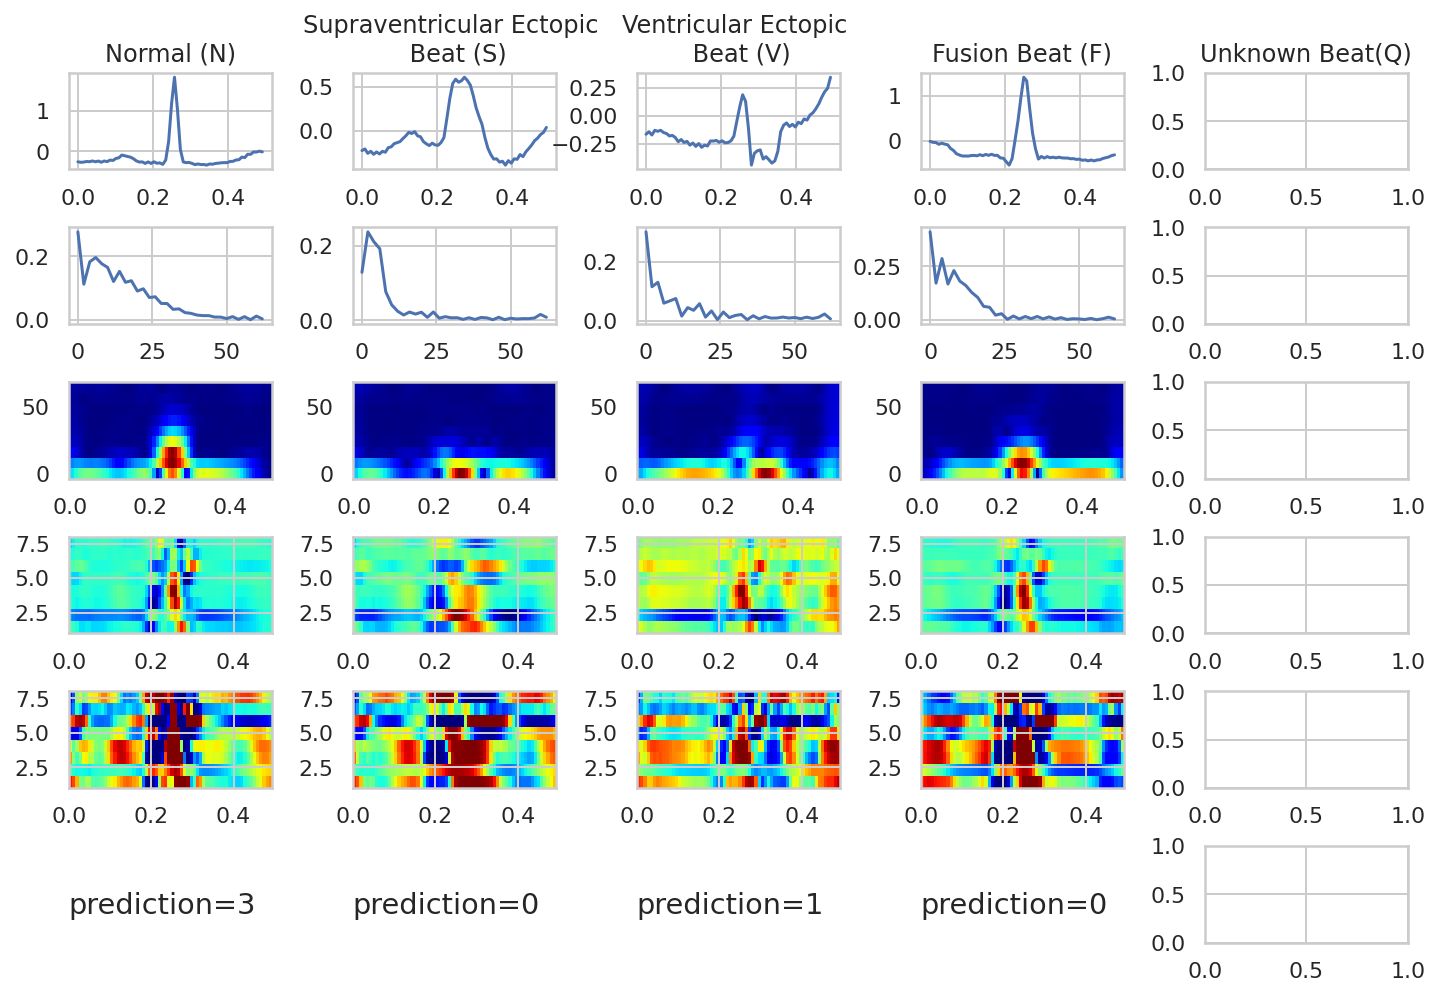

In [57]:
from random import seed
from random import randint

seed(40)

fig, axes = plt.subplots(6, 5, figsize=(12,8))
    
#fig = plt.figure(figsize=(12,6))
#plt.tight_layout()
fig.subplots_adjust(hspace=0.6, wspace=0.4)

N = X_tst_tf.shape[1]
t = np.arange(N)*1/fs
f=fftfreq(N, 1/fs)[:N//2]

col = ['Normal (N)', 'Supraventricular Ectopic \n Beat (S)', 'Ventricular Ectopic \n Beat (V)', 'Fusion Beat (F)', 'Unknown Beat(Q)']

for ax, col in zip(axes[0], col):
    ax.set_title(col)


for i in range(num_classes):
    random_instance = randint(0,10)
    class_index = np.where(cls_data[i]['hit']==False)[0][random_instance] ## Set True
    signal = X_tst_tf[cls_data[i]['class_indices'][class_index]].reshape(-1) 
    axes[0, i].plot(t, signal)
    x_f = 2.0/N * np.abs(fft(signal)[0:N//2])
    axes[1, i].plot(f,x_f)
    f2, t2, spectrogram = stft(signal, fs=fs, nperseg=16, noverlap=15, nfft=16, padded=True)
    #spectrogram = np.abs(stft(signal, fs=fs, nperseg=16, noverlap=15, nfft=16, padded=True)[2])
    #axes[2,i].imshow(spectrogram,cmap='jet',aspect='auto',origin='lower')
    axes[2,i].pcolormesh(t2,f2,np.abs(spectrogram),cmap='jet',shading='auto')
    axes[3,i].imshow(cls_data[i]['Conv1D_Outputs'][class_index].transpose(),
                     extent=[min(t),max(t),1,conv1d_filters],
                     cmap='jet',aspect='auto',origin='lower')
    axes[4,i].imshow(cls_data[i]['Conv1D_Activations'][class_index].transpose(),
                     extent=[min(t),max(t),1,conv1d_filters],
                     cmap='jet',aspect='auto',origin='lower')
    #axes[5,i].text(0,0.7,np.array2string(pred_prob[cls_data[i]['class_indices'][class_index]], 
    #                                       precision=2, separator=',',suppress_small=True),size='large')
    axes[5,i].text(0,0.3,"prediction=" + np.array2string(y_pred[cls_data[i]['class_indices'][class_index]], 
                                                           precision=2, separator=',',suppress_small=True),size='large')
    axes[5,i].axis('off')
    #axes[3,i].pcolormesh(t,np.arange(16),cls_data[i]['activations'][class_index],cmap='jet', shading='auto')

# Plot samples of ECG waveforms

In [ ]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, 
                         constrained_layout=True,figsize=(8,5))

fig.text(0.5, -0.04, 'time (seconds)', ha='center', fontfamily = 'serif', fontsize = 18)
fig.text(-0.04, 0.5, 'Amplitude', va='center', rotation='vertical',fontfamily = 'serif', fontsize = 18)

col = ['Normal (N)', 'Supraventricular Ectopic \n Beat (S)', 'Ventricular Ectopic \n Beat (V)', 'Fusion Beat (F)', 'Unknown Beat(Q)']

for ax, col in zip(axes[0], col):
    ax.set_title(col)

for i in range(num_classes):
    for j in range(5):
        random_instance = randint(0,50)
        signal = X_tst_tf[cls_data[i]['class_indices'][random_instance]]
        axes[j,i].plot(t, signal)

fig.suptitle('Sample instances of the ECG waveforms')

# Post Training Optimization

## Convert best model to tflite with floating points

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

base_model_size = os.stat('./models/best_model.h5').st_size / 1024
print('Base model size = %dKBs.' % base_model_size)

tflite_model_size = len(tflite_model) / 1024
print('tflite model size = %dKBs.' % tflite_model_size)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()[0]

  # Run predictions on every image in the "test" dataset.
  y_pred = []
  prediction_proba = []
  for data, T in zip(X_tst_tf,T_tst_tf):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    if input_details[0]['dtype'] == np.int8:
      input_scale, input_zero_point = input_details[0]["quantization"]
      #print('scale=',input_scale,'zero_point = ', input_zero_point )
      data = data / input_scale + input_zero_point

    if input_details[1]['dtype'] == np.int8:
      input_scale, input_zero_point = input_details[1]["quantization"]
      #print('scale=',input_scale,'zero_point = ', input_zero_point )
      T = T / input_scale + input_zero_point
    
    # Check if the input type is quantized, then rescale input data to int8
    test_data = np.expand_dims(data, axis=0).astype(input_details[0]["dtype"])
    test_T = np.expand_dims(T, axis=0).astype(input_details[1]["dtype"])
    
    interpreter.set_tensor(input_details[0]['index'], test_data)
    interpreter.set_tensor(input_details[1]['index'], test_T)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    predict_prob=output()[0]/sum(output()[0])
    prediction_proba.append(predict_prob)
    prediction = np.argmax(output()[0])
    y_pred.append(prediction)

  target_names=[0,1,2,3,4]
    
  cnf_matrix = confusion_matrix(y_tst, y_pred,target_names,normalize='true')
  np.set_printoptions(precision=2)
  sns.set_style("dark")

  # Plot non-normalized confusion matrix
  plt.figure(figsize=(5, 5))
  plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
  plt.show()    

  acc_scr = accuracy_score(y_tst,y_pred)
  recall_scr = recall_score(y_tst,y_pred, average='macro')
  f1_scr = f1_score(y_tst,y_pred, average='macro')
  auc_scr = roc_auc_score(y_tst,prediction_proba, average='macro',multi_class='ovr')

  print("accuracy score = ", acc_scr)
  print("recall score = ", recall_scr)    
  print("f1 score = ", f1_scr)
  print("auc score = ", auc_scr)
    
  float_formatter = "{:.2f}".format    
  np.set_printoptions(formatter={'float_kind':float_formatter})    
  print(classification_report(y_tst, y_pred, target_names,digits=4))
  print(cnf_matrix)
  
  return [acc_scr, recall_scr, f1_scr, auc_scr]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


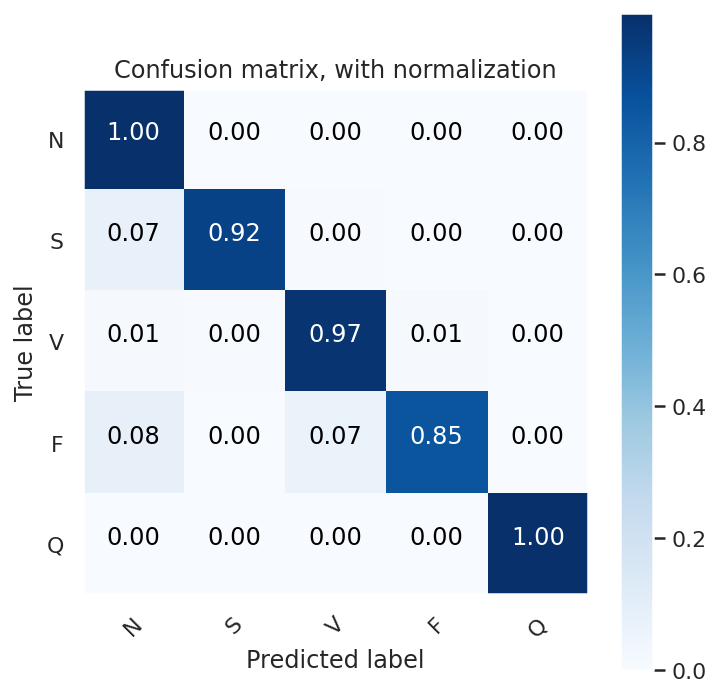

accuracy score =  0.9908139534883721
recall score =  0.9491746884617651
f1 score =  0.9433981469925611
auc score =  0.9974292237834039
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22137
           1       0.91      0.92      0.91       692
           2       0.98      0.97      0.98      1797
           3       0.82      0.85      0.84       200
           4       0.99      1.00      0.99       974

    accuracy                           0.99     25800
   macro avg       0.94      0.95      0.94     25800
weighted avg       0.99      0.99      0.99     25800

[[1.00 0.00 0.00 0.00 0.00]
 [0.07 0.92 0.00 0.00 0.00]
 [0.01 0.00 0.97 0.01 0.00]
 [0.08 0.00 0.07 0.85 0.00]
 [0.00 0.00 0.00 0.00 1.00]]
float32 tflite model accuracy = 0.9908
float32 tflite model recall score = 0.9492
float32 tflite model f1 score = 0.9434
float32 tflite model auc score = 0.9974


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [78]:
# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
tflite_results = evaluate_tflite_model(tflite_model)
print('float32 tflite model accuracy = %.4f' % tflite_results[0])
print('float32 tflite model recall score = %.4f' % tflite_results[1])
print('float32 tflite model f1 score = %.4f' % tflite_results[2])
print('float32 tflite model auc score = %.4f' % tflite_results[3])

In [79]:
# Save the tflite model to file to the Downloads directory
f = open('./models/float32.tflite', "wb")
f.write(tflite_model)
f.close()

In [80]:
#Update Results
results_dict['model_name'].append('float32 tflite')
results_dict['no_par'].append(model.count_params())
results_dict['trn_t'].append('NA')
results_dict['trn_mem'].append('NA')
results_dict['trn_acc'].append('NA')
results_dict['tst_acc'].append(tflite_results[0])
results_dict['recall_scr'].append(tflite_results[1])
results_dict['f1_scr'].append(tflite_results[2])
results_dict['auc_scr'].append(tflite_results[3])
results_dict['cpu_inf_t'].append('TBD')
results_dict['cpu_thrpt'].append('TBD')
results_dict['gpu_inf_t'].append('NA')
results_dict['gpu_thrpt'].append('NA')
results_dict['model_size'].append(len(tflite_model))
results_dict['gzipped_size'].append('NA')

## Float16 quantization
You can reduce the size of a floating point model by quantizing the weights to float16, the IEEE standard for 16-bit floating point numbers. To enable float16 quantization of weights, use the following steps:

The advantages of float16 quantization are as follows:

It reduces model size by up to half (since all weights become half of their original size).
It causes minimal loss in accuracy.
It supports some delegates (e.g. the GPU delegate) which can operate directly on float16 data, resulting in faster execution than float32 computations.
The disadvantages of float16 quantization are as follows:

It does not reduce latency as much as a quantization to fixed point math.
By default, a float16 quantized model will "dequantize" the weights values to float32 when run on the CPU. (Note that the GPU delegate will not perform this dequantization, since it can operate on float16 data.)

In [81]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quant_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpn6gcgori/assets


INFO:tensorflow:Assets written to: /tmp/tmpn6gcgori/assets


In [82]:
quant_model_size = len(quant_tflite_model) / 1024
print('Float16 Quantized model size = %dKBs,' % quant_model_size)
print('which is about %d%% of the float model size.'\
      % (quant_model_size * 100 / tflite_model_size))

Float16 Quantized model size = 45KBs,
which is about 65% of the float model size.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


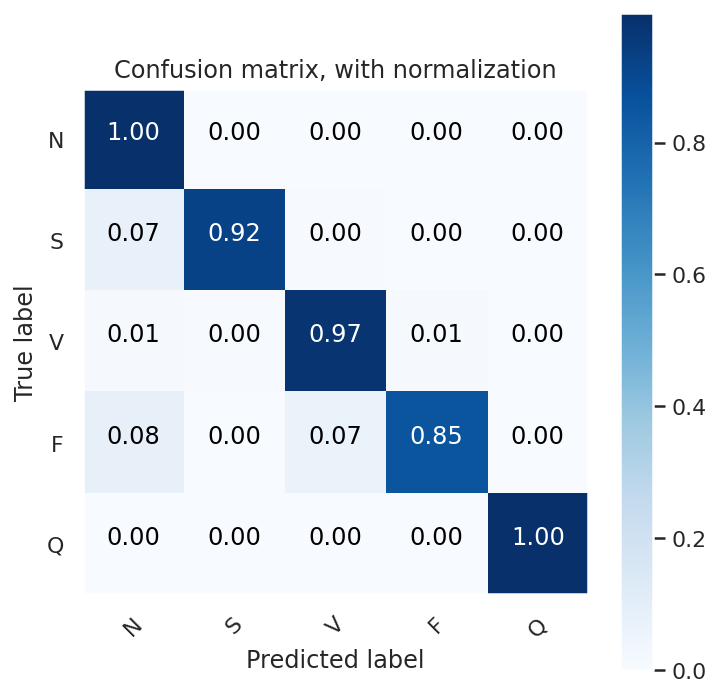

accuracy score =  0.9908139534883721
recall score =  0.9491746884617651
f1 score =  0.9433981469925611
auc score =  0.9974284597421601
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22137
           1       0.91      0.92      0.91       692
           2       0.98      0.97      0.98      1797
           3       0.82      0.85      0.84       200
           4       0.99      1.00      0.99       974

    accuracy                           0.99     25800
   macro avg       0.94      0.95      0.94     25800
weighted avg       0.99      0.99      0.99     25800

[[1.00 0.00 0.00 0.00 0.00]
 [0.07 0.92 0.00 0.00 0.00]
 [0.01 0.00 0.97 0.01 0.00]
 [0.08 0.00 0.07 0.85 0.00]
 [0.00 0.00 0.00 0.00 1.00]]
float16 tflite model accuracy = 0.9908
float16 tflite model recall score = 0.9492
float16 tflite model f1 score = 0.9434
float16 tflite model auc score = 0.9974
Accuracy drop = 0.0000


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [83]:
# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quant_tflite_results = evaluate_tflite_model(quant_tflite_model)
print('float16 tflite model accuracy = %.4f' % quant_tflite_results[0])
print('float16 tflite model recall score = %.4f' % quant_tflite_results[1])
print('float16 tflite model f1 score = %.4f' % quant_tflite_results[2])
print('float16 tflite model auc score = %.4f' % quant_tflite_results[3])
print('Accuracy drop = %.4f' % (tflite_results[0] - quant_tflite_results[0]))

In [84]:
# Save the tflite model to file to the Downloads directory
f = open('./models/float16.tflite', "wb")
f.write(quant_tflite_model)
f.close()

In [85]:
#Update Results
results_dict['model_name'].append('float16 tflite')
results_dict['no_par'].append(model.count_params())
results_dict['trn_t'].append('NA')
results_dict['trn_mem'].append('NA')
results_dict['trn_acc'].append('NA')
results_dict['tst_acc'].append(quant_tflite_results[0])
results_dict['recall_scr'].append(quant_tflite_results[1])
results_dict['f1_scr'].append(quant_tflite_results[2])
results_dict['auc_scr'].append(quant_tflite_results[3])
results_dict['cpu_inf_t'].append('TBD')
results_dict['cpu_thrpt'].append('TBD')
results_dict['gpu_inf_t'].append('NA')
results_dict['gpu_thrpt'].append('NA')
results_dict['model_size'].append(len(quant_tflite_model))
results_dict['gzipped_size'].append('NA')

## Dynamic range quantization of tflite from best model
The simplest form of post-training quantization statically quantizes only the weights from floating point to integer, which has 8-bits of precision:
At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.
To further improve latency, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point so that the speedup with dynamic-range ops is less than a full fixed-point computation.

In [86]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpae3z2g0h/assets


INFO:tensorflow:Assets written to: /tmp/tmpae3z2g0h/assets


In [87]:
quant_model_size = len(quant_tflite_model) / 1024
print('Dynamic Range Quantized model size = %dKBs,' % quant_model_size)
print('which is about %d%% of the float model size.'\
      % (quant_model_size * 100 / tflite_model_size))

Dynamic Range Quantized model size = 35KBs,
which is about 51% of the float model size.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


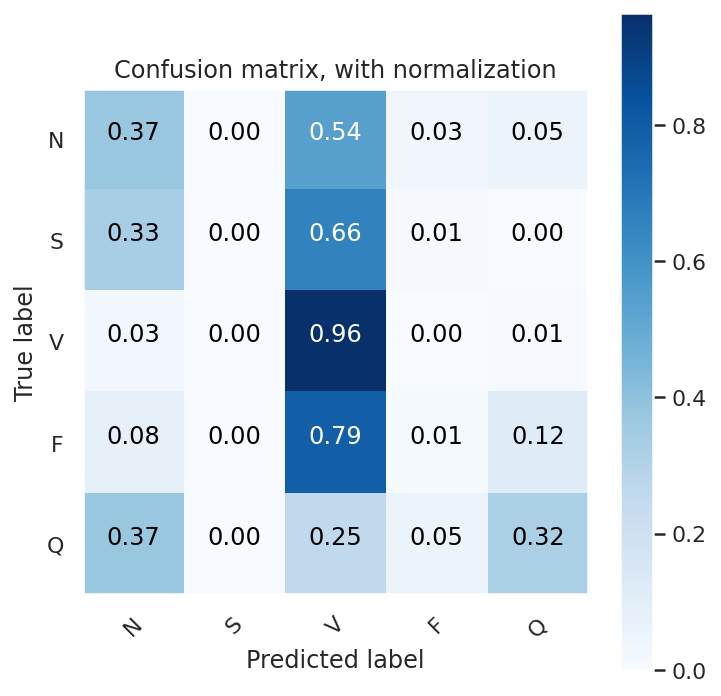

accuracy score =  0.4003875968992248
recall score =  0.3349639835284549
f1 score =  0.20148303228452163
auc score =  0.7037378794505817
              precision    recall  f1-score   support

           0       0.93      0.37      0.53     22137
           1       0.00      0.00      0.00       692
           2       0.12      0.96      0.21      1797
           3       0.00      0.01      0.01       200
           4       0.21      0.32      0.26       974

    accuracy                           0.40     25800
   macro avg       0.25      0.33      0.20     25800
weighted avg       0.81      0.40      0.48     25800

[[0.37 0.00 0.54 0.03 0.05]
 [0.33 0.00 0.66 0.01 0.00]
 [0.03 0.00 0.96 0.00 0.01]
 [0.08 0.00 0.79 0.01 0.12]
 [0.37 0.00 0.25 0.05 0.32]]
Dyn_range tflite model accuracy = 0.4004
Dyn_range tflite model recall score = 0.3350
Dyn_range tflite model f1 score = 0.2015
Dyn_range tflite model auc score = 0.7037
Accuracy drop = 0.5904


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [88]:
# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quant_tflite_results = evaluate_tflite_model(quant_tflite_model)
print('Dyn_range tflite model accuracy = %.4f' % quant_tflite_results[0])
print('Dyn_range tflite model recall score = %.4f' % quant_tflite_results[1])
print('Dyn_range tflite model f1 score = %.4f' % quant_tflite_results[2])
print('Dyn_range tflite model auc score = %.4f' % quant_tflite_results[3])
print('Accuracy drop = %.4f' % (tflite_results[0] - quant_tflite_results[0]))

In [89]:
# Save the tflite model to file to the Downloads directory
f = open('./models/dyn_range.tflite', "wb")
f.write(quant_tflite_model)
f.close()

In [90]:
#Update Results
results_dict['model_name'].append('dynamic range tflite')
results_dict['no_par'].append(model.count_params())
results_dict['trn_t'].append('NA')
results_dict['trn_mem'].append('NA')
results_dict['trn_acc'].append('NA')
results_dict['tst_acc'].append(quant_tflite_results[0])
results_dict['recall_scr'].append(quant_tflite_results[1])
results_dict['f1_scr'].append(quant_tflite_results[2])
results_dict['auc_scr'].append(quant_tflite_results[3])
results_dict['cpu_inf_t'].append('TBD')
results_dict['cpu_thrpt'].append('TBD')
results_dict['gpu_inf_t'].append('NA')
results_dict['gpu_thrpt'].append('NA')
results_dict['model_size'].append(len(quant_tflite_model))
results_dict['gzipped_size'].append('NA')

## Full integer quantization
You can get further latency improvements, reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by making sure all model math is integer quantized.

For full integer quantization, you need to calibrate or estimate the range, i.e, (min, max) of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. Refer to the representative_dataset() function below.

#Integer with float fallback (using default float input/output)
In order to fully integer quantize a model, but use float operators when they don't have an integer implementation (to ensure conversion occurs smoothly), use the following steps:

In [91]:
def representative_data_gen():
    for input_value,T_value in zip(tf.data.Dataset.from_tensor_slices(X_trn_tf).batch(1).take(100),
                                   tf.data.Dataset.from_tensor_slices(T_trn_tf).batch(1).take(100)):
        yield [input_value,T_value]        

In [92]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quant_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp6btphdf4/assets


INFO:tensorflow:Assets written to: /tmp/tmp6btphdf4/assets


In [93]:
quant_model_size = len(quant_tflite_model) / 1024
print('full integer Quantized model size = %dKBs,' % quant_model_size)
print('which is about %d%% of the float model size.'\
      % (quant_model_size * 100 / tflite_model_size))

full integer Quantized model size = 34KBs,
which is about 48% of the float model size.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


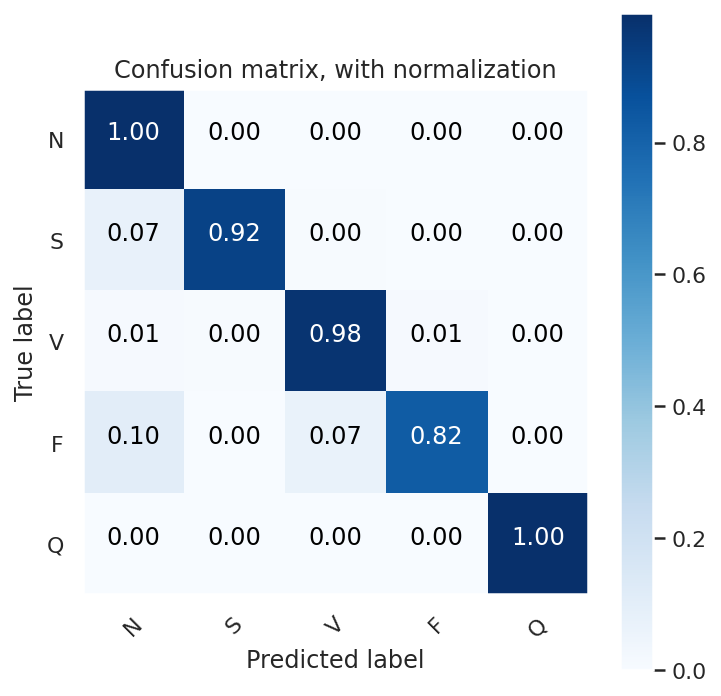

accuracy score =  0.9907751937984496
recall score =  0.9433489268382882
f1 score =  0.941554502711403
auc score =  0.9865086904615789
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22137
           1       0.91      0.92      0.92       692
           2       0.98      0.98      0.98      1797
           3       0.82      0.82      0.82       200
           4       0.99      1.00      0.99       974

    accuracy                           0.99     25800
   macro avg       0.94      0.94      0.94     25800
weighted avg       0.99      0.99      0.99     25800

[[1.00 0.00 0.00 0.00 0.00]
 [0.07 0.92 0.00 0.00 0.00]
 [0.01 0.00 0.98 0.01 0.00]
 [0.10 0.00 0.07 0.82 0.00]
 [0.00 0.00 0.00 0.00 1.00]]
full_int tflite model accuracy = 0.9908
full_int tflite model recall score = 0.9433
full_int tflite model f1 score = 0.9416
full_int tflite model auc score = 0.9865
Accuracy drop = 0.0000


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [94]:
# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quant_tflite_results = evaluate_tflite_model(quant_tflite_model)
print('full_int tflite model accuracy = %.4f' % quant_tflite_results[0])
print('full_int tflite model recall score = %.4f' % quant_tflite_results[1])
print('full_int tflite model f1 score = %.4f' % quant_tflite_results[2])
print('full_int tflite model auc score = %.4f' % quant_tflite_results[3])
print('Accuracy drop = %.4f' % (tflite_results[0] - quant_tflite_results[0]))

In [95]:
# Save the tflite model to file to the Downloads directory
f = open('./models/full_int.tflite', "wb")
f.write(quant_tflite_model)
f.close()

In [96]:
#Update Results
results_dict['model_name'].append('full integer tflite')
results_dict['no_par'].append(model.count_params())
results_dict['trn_t'].append('NA')
results_dict['trn_mem'].append('NA')
results_dict['trn_acc'].append('NA')
results_dict['tst_acc'].append(quant_tflite_results[0])
results_dict['recall_scr'].append(quant_tflite_results[1])
results_dict['f1_scr'].append(quant_tflite_results[2])
results_dict['auc_scr'].append(quant_tflite_results[3])
results_dict['cpu_inf_t'].append('TBD')
results_dict['cpu_thrpt'].append('TBD')
results_dict['gpu_inf_t'].append('NA')
results_dict['gpu_thrpt'].append('NA')
results_dict['model_size'].append(len(quant_tflite_model))
results_dict['gzipped_size'].append('NA')

## Integer only
Creating integer only models is a common use case for TensorFlow Lite for Microcontrollers and Coral Edge TPUs.
Additionally, to ensure compatibility with integer only devices (such as 8-bit microcontrollers) and accelerators (such as the Coral Edge TPU), you can enforce full integer quantization for all ops including the input and output, by using the following steps:

In [97]:
# Re-convert the model to TF Lite using quantization.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set int8 is the supported type on the target platform
#converter.target_spec.supported_types = [tf.uint8]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
quant_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3dq2filf/assets


INFO:tensorflow:Assets written to: /tmp/tmp3dq2filf/assets


In [98]:
quant_model_size = len(quant_tflite_model) / 1024
print('Int8 Quantized model size = %dKBs,' % quant_model_size)
print('which is about %d%% of the float model size.'\
      % (quant_model_size * 100 / tflite_model_size))

Int8 Quantized model size = 33KBs,
which is about 47% of the float model size.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


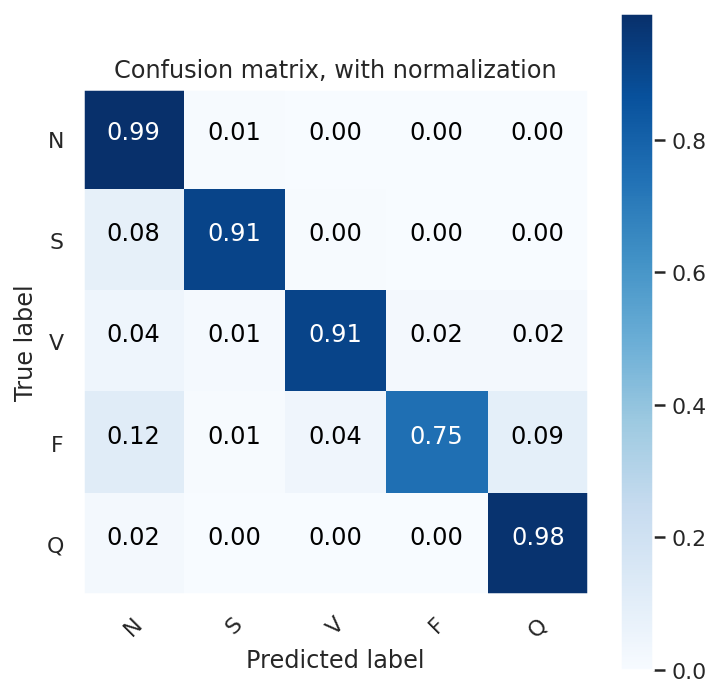

accuracy score =  0.9811627906976744
recall score =  0.9085916908501425
f1 score =  0.8999788201315336
auc score =  0.02983139610594001
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22137
           1       0.82      0.91      0.86       692
           2       0.98      0.91      0.94      1797
           3       0.76      0.75      0.76       200
           4       0.92      0.98      0.95       974

    accuracy                           0.98     25800
   macro avg       0.89      0.91      0.90     25800
weighted avg       0.98      0.98      0.98     25800

[[0.99 0.01 0.00 0.00 0.00]
 [0.08 0.91 0.00 0.00 0.00]
 [0.04 0.01 0.91 0.02 0.02]
 [0.12 0.01 0.04 0.75 0.09]
 [0.02 0.00 0.00 0.00 0.98]]
int8 tflite model accuracy = 0.9812
int8 tflite model recall score = 0.9086
int8 tflite model f1 score = 0.9000
int8 tflite model auc score = 0.0298
Accuracy drop = 0.0097


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [99]:
# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quant_tflite_results = evaluate_tflite_model(quant_tflite_model)
print('int8 tflite model accuracy = %.4f' % quant_tflite_results[0])
print('int8 tflite model recall score = %.4f' % quant_tflite_results[1])
print('int8 tflite model f1 score = %.4f' % quant_tflite_results[2])
print('int8 tflite model auc score = %.4f' % quant_tflite_results[3])
print('Accuracy drop = %.4f' % (tflite_results[0] - quant_tflite_results[0]))

In [100]:
# Save the tflite model to file to the Downloads directory
f = open('./models/int8.tflite', "wb")
f.write(quant_tflite_model)
f.close()

In [101]:
#Update Results
results_dict['model_name'].append('int8 tflite')
results_dict['no_par'].append(model.count_params())
results_dict['trn_t'].append('NA')
results_dict['trn_mem'].append('NA')
results_dict['trn_acc'].append('NA')
results_dict['tst_acc'].append(quant_tflite_results[0])
results_dict['recall_scr'].append(quant_tflite_results[1])
results_dict['f1_scr'].append(quant_tflite_results[2])
results_dict['auc_scr'].append(quant_tflite_results[3])
results_dict['cpu_inf_t'].append('TBD')
results_dict['cpu_thrpt'].append('TBD')
results_dict['gpu_inf_t'].append('NA')
results_dict['gpu_thrpt'].append('NA')
results_dict['model_size'].append(len(quant_tflite_model))
results_dict['gzipped_size'].append('NA')

# Quantization-Aware Training

## Int8 Qkeras Pruning Quantization of the base Model

In [102]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import defaultdict

from qkeras import *

In [103]:
config = {
  "QConv1D": {
      "kernel_quantizer": "quantized_bits(8, 0, 1)",
      "bias_quantizer": "quantized_bits(8, 0, 1)"
  },
  "QConv2D": {
      "kernel_quantizer": "quantized_bits(8, 0, 1)",
      "bias_quantizer": "quantized_bits(8, 0, 1)"
  },    
  "QDense": {
      "kernel_quantizer": "quantized_bits(8, 0, 1)",
      "bias_quantizer": "quantized_bits(8, 0, 1)"
  },
  "QActivation": { "relu": "quantized_relu(8,0)",
                  "tanh": "quantized_tanh(8,0)"
    },
  "QBatchNormalization": {}    
}

In [104]:
from qkeras.utils import model_quantize

qmodel = model_quantize(model, config, 8, transfer_weights=True)

for layer in qmodel.layers:
    if hasattr(layer, "kernel_quantizer"):
        print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
    elif hasattr(layer, "quantizer"):
        print(layer.name, "quantizer:", str(layer.quantizer))

print()
qmodel.summary()

Conv1DLayer_1 kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
activation_4 quantizer: quantized_tanh(8)
Conv2DLayer_1 kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
activation_5 quantizer: quantized_relu(8,0)
Conv2DLayer_2 kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
activation_6 quantizer: quantized_relu(8,0)
Conv2DLayer_f kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
Dense_T1 kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
activation_7 quantizer: quantized_relu(8,0)
Dense_T2 kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
Dense_T3 kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)
OuputLayer kernel: quantized_bits(8,0,1,alpha='auto_po2') bias: quantized_bits(8,0,1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)   

In [105]:
import tensorflow_model_optimization as tfmot

from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule

In [106]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_examples = X_trn_tf.shape[0]
end_step = np.ceil(num_examples / batch_size).astype(np.int32) * epochs

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.5, begin_step=1000, frequency=1000)}

# Define model for pruning.
#pruning_params = {
#      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.90,
#                                                               begin_step=2000, end_step=end_step)}

pq_model = prune_low_magnitude(qmodel, **pruning_params)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                             decay_steps=1024,decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule) 
loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2) #loss = 'categorical_crossentropy'

pq_model.compile(loss=loss, optimizer=opt, metrics=['accuracy',
                                                     keras.metrics.AUC(),
                                                     tfa.metrics.F1Score(num_classes=5, average='macro'),
                                                     keras.metrics.Recall()])

#F1_scr = F1_score(n_class=5)
#pq_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', F1_scr])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [107]:
from tempfile import TemporaryDirectory

with TemporaryDirectory() as temp_dir:

    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
      tfmot.sparsity.keras.PruningSummaries(log_dir=temp_dir),
      EarlyStopping(monitor='val_loss', patience=50),
      ModelCheckpoint(filepath='./models/pq_model.h5', 
      monitor='val_f1_score', mode='max', save_best_only=True)
    ]

    start=time.time()
    # fit network
    history=pq_model.fit((X_trn_tf,T_trn_tf), y_trn_oh, epochs=epochs,callbacks=callbacks, 
                          batch_size=batch_size, validation_split=0.25,shuffle=True)
    end=time.time()
    training_time= end - start
    
    pq_model.load_weights('./models/pq_model.h5')
    #pq_model.save('./models/pq_model.h5',include_optimizer=False)
    

Epoch 1/500
  5/114 [>.............................] - ETA: 35s - loss: 0.1596 - accuracy: 0.9072 - auc_2: 0.9822 - f1_score: 0.5670 - recall_2: 0.8967 WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0361s vs `on_train_batch_begin` time: 0.0699s). Check your callbacks.


114/114 [==============================] - 17s 69ms/step - loss: 0.0630 - accuracy: 0.9485 - auc_2: 0.9935 - f1_score: 0.7645 - recall_2: 0.9397 - val_loss: 0.0487 - val_accuracy: 0.9399 - val_auc_2: 0.9937 - val_f1_score: 0.7123 - val_recall_2: 0.9230
Epoch 2/500
114/114 [==============================] - 5s 39ms/step - loss: 0.0171 - accuracy: 0.9795 - auc_2: 0.9990 - f1_score: 0.8895 - recall_2: 0.9735 - val_loss: 0.0228 - val_accuracy: 0.9715 - val_auc_2: 0.9982 - val_f1_score: 0.8614 - val_recall_2: 0.9634
Epoch 3/500
114/114 [==============================] - 4s 38ms/step - loss: 0.0120 - accuracy: 0.9848 - auc_2: 0.9995 - f1_score: 0.9123 - recall_2: 0.9801 - val_loss: 0.0197 - val_accuracy: 0.9801 - val_auc_2: 0.9988 - val_f1_score: 0.8925 - val_recall_2: 0.9770
Epoch 4/500
114/114 [==============================] - 4s 39ms/step - loss: 0.0101 - accuracy: 0.9865 - auc_2: 0.9996 - f1_score: 0.9221 - recall_2: 0.9822 - val_loss: 0.0158 - val_accuracy: 0.9817 - val_auc_2: 0.9991 -

Epoch 32/500
114/114 [==============================] - 4s 38ms/step - loss: 0.0016 - accuracy: 0.9979 - auc_2: 1.0000 - f1_score: 0.9851 - recall_2: 0.9970 - val_loss: 0.0141 - val_accuracy: 0.9866 - val_auc_2: 0.9993 - val_f1_score: 0.9266 - val_recall_2: 0.9838
Epoch 33/500
114/114 [==============================] - 4s 39ms/step - loss: 0.0016 - accuracy: 0.9979 - auc_2: 1.0000 - f1_score: 0.9864 - recall_2: 0.9965 - val_loss: 0.0143 - val_accuracy: 0.9865 - val_auc_2: 0.9993 - val_f1_score: 0.9270 - val_recall_2: 0.9839
Epoch 34/500
114/114 [==============================] - 4s 38ms/step - loss: 0.0022 - accuracy: 0.9966 - auc_2: 1.0000 - f1_score: 0.9799 - recall_2: 0.9954 - val_loss: 0.0145 - val_accuracy: 0.9872 - val_auc_2: 0.9993 - val_f1_score: 0.9267 - val_recall_2: 0.9851
Epoch 35/500
114/114 [==============================] - 5s 41ms/step - loss: 0.0020 - accuracy: 0.9971 - auc_2: 1.0000 - f1_score: 0.9800 - recall_2: 0.9963 - val_loss: 0.0135 - val_accuracy: 0.9860 - val_

In [108]:
model_size = os.stat('./models/pq_model.h5').st_size
trn_mem=tf.config.experimental.get_memory_usage("GPU:0")

2419/2419 [==============================] - 23s 9ms/step - loss: 0.0043 - accuracy: 0.9969 - auc_2: 0.9999 - f1_score: 0.9827 - recall_2: 0.9966
Train loss: 0.0042871455661952496, Train accuracy: 0.9969379305839539
807/807 [==============================] - 8s 9ms/step - loss: 0.0131 - accuracy: 0.9901 - auc_2: 0.9996 - f1_score: 0.9357 - recall_2: 0.9893
Test loss: 0.013063597492873669, Test accuracy: 0.9901162981987


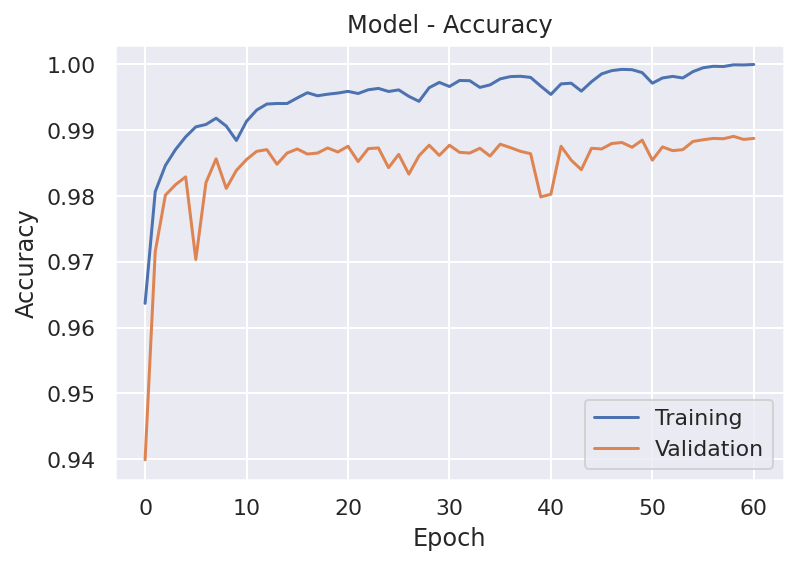

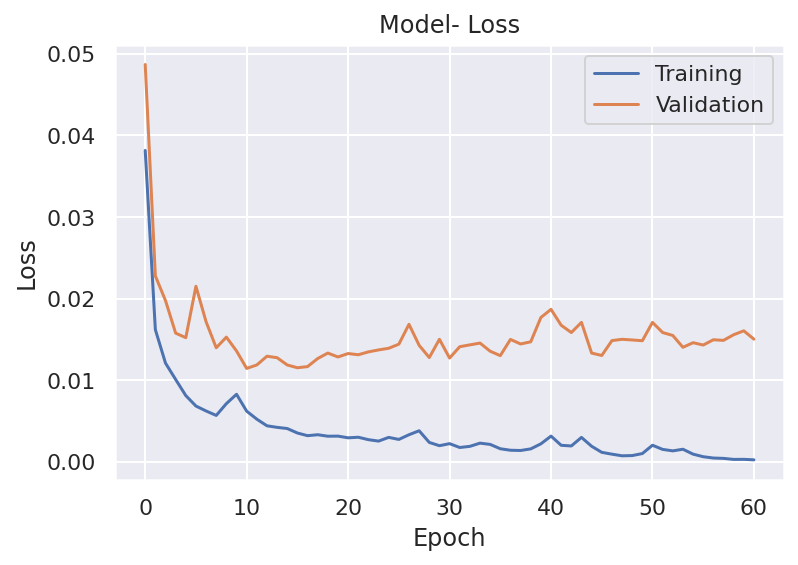

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


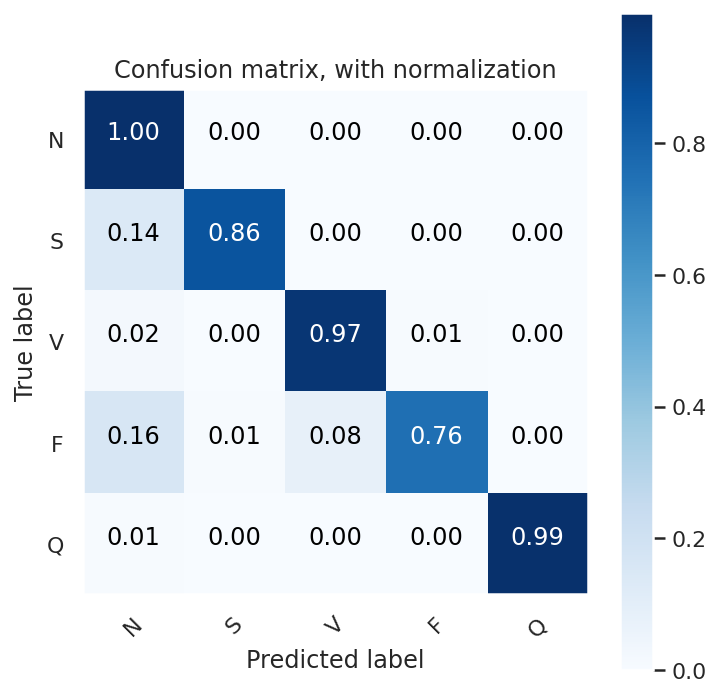

accuracy score =  0.9901162790697674
recall score =  0.9154178555156669
f1 score =  0.935743993928169
auc score =  0.99654257184754
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22137
           1       0.95      0.86      0.90       692
           2       0.98      0.97      0.98      1797
           3       0.87      0.76      0.81       200
           4       1.00      0.99      1.00       974

    accuracy                           0.99     25800
   macro avg       0.96      0.92      0.94     25800
weighted avg       0.99      0.99      0.99     25800

[[1.00 0.00 0.00 0.00 0.00]
 [0.14 0.86 0.00 0.00 0.00]
 [0.02 0.00 0.97 0.01 0.00]
 [0.16 0.01 0.08 0.76 0.00]
 [0.01 0.00 0.00 0.00 0.99]]
CPU times: user 49.4 s, sys: 4.57 s, total: 53.9 s
Wall time: 37.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [109]:
%%time
scores = evaluate_model(pq_model,history)

In [110]:
with tf.device('/cpu:0'):
    start = time.time()
    pq_model.predict((X_tst_tf,T_tst_tf))
    end = time.time()

cpu_inference_time =  (end-start)/X_tst_tf.shape[0]
cpu_throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on CPU is :", cpu_inference_time)
print("Throughput on CPU is :", cpu_throughput, "sequence per second")

Inference on CPU is : 0.00032080896140993106
Throughput on CPU is : 3117.119907140611 sequence per second


In [111]:
with tf.device('/gpu:0'):
    start = time.time()
    pq_model.predict((X_tst_tf,T_tst_tf))
    end = time.time()

gpu_inference_time =  (end-start)/X_tst_tf.shape[0]
gpu_throughput = X_tst_tf.shape[0]/(end-start)

print("Inference on GPU is :", gpu_inference_time)
print("Throughput on GPU is :", gpu_throughput, "sequence per second")

Inference on GPU is : 0.00021682506383851517
Throughput on GPU is : 4612.012939356357 sequence per second


In [112]:
## Update results

results_dict['model_name'].append('pq keras model')
results_dict['no_par'].append(pq_model.count_params())
results_dict['trn_t'].append(training_time)
results_dict['trn_mem'].append(trn_mem)
results_dict['trn_acc'].append(scores[0])
results_dict['tst_acc'].append(scores[1])
results_dict['recall_scr'].append(scores[2])
results_dict['f1_scr'].append(scores[3])
results_dict['auc_scr'].append(scores[4])
results_dict['cpu_inf_t'].append(cpu_inference_time)
results_dict['cpu_thrpt'].append(cpu_throughput)
results_dict['gpu_inf_t'].append(gpu_inference_time)
results_dict['gpu_thrpt'].append(gpu_throughput)
results_dict['model_size'].append(model_size)
results_dict['gzipped_size'].append(get_gzipped_model_size(pq_model))

In [113]:
from qkeras.utils import *

print_model_sparsity(pq_model)

Model Sparsity Summary (model_1)
--
prune_low_magnitude_Conv1DLayer_1: (Conv1DLayer_1/kernel:0, 0.5)
prune_low_magnitude_Conv2DLayer_1: (Conv2DLayer_1/kernel:0, 0.5)
prune_low_magnitude_Conv2DLayer_2: (Conv2DLayer_2/kernel:0, 0.5)
prune_low_magnitude_Conv2DLayer_f: (Conv2DLayer_f/kernel:0, 0.5)
prune_low_magnitude_Dense_T1: (Dense_T1/kernel:0, 0.5)
prune_low_magnitude_Dense_T2: (Dense_T2/kernel:0, 0.5)
prune_low_magnitude_Dense_T3: (Dense_T3/kernel:0, 0.5)
prune_low_magnitude_OuputLayer: (OuputLayer/kernel:0, 0.5)




In [114]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [115]:
print_model_sparsity(model)

Model Sparsity Summary (model_1)
--
Conv1DLayer_1: (Conv1DLayer_1/kernel:0, 0.0)
Conv2DLayer_1: (Conv2DLayer_1/kernel:0, 0.0)
Conv2DLayer_2: (Conv2DLayer_2/kernel:0, 0.0)
Conv2DLayer_f: (Conv2DLayer_f/kernel:0, 0.0)
Dense_T1: (Dense_T1/kernel:0, 0.0)
Dense_T2: (Dense_T2/kernel:0, 0.0)
Dense_T3: (Dense_T3/kernel:0, 0.0)
OuputLayer: (OuputLayer/kernel:0, 0.0)




In [116]:
print_model_weights_sparsity(pq_model)

Conv1DLayer_1/kernel:0: 50.00% sparsity  (64/128)
Conv2DLayer_1/kernel:0: 50.00% sparsity  (256/512)
Conv2DLayer_2/kernel:0: 50.00% sparsity  (4096/8192)
Conv2DLayer_f/kernel:0: 50.00% sparsity  (2048/4096)
Dense_T1/kernel:0: 50.00% sparsity  (16/32)
Dense_T2/kernel:0: 50.00% sparsity  (256/512)
Dense_T3/kernel:0: 50.00% sparsity  (64/128)
OuputLayer/kernel:0: 50.00% sparsity  (360/720)


In [117]:
try:
    quantized_model_debug(pq_model, X_tst_tf, plot=True)
except Exception as ex:
    print(ex)

plt_instance is required if plt is True


# Strip Pruning

In [118]:
pqs_model = tfmot.sparsity.keras.strip_pruning(pq_model)
pqs_model.save("./models/pqs_model.h5",include_optimizer=False)

In [119]:
model_size = os.stat('./models/pqs_model.h5').st_size

print('Pruned stripped model size = %dKBs.' % (model_size/1024))

Pruned stripped model size = 129KBs.


In [120]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(model)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pq_model)))
print("Size of gzipped pruned stripped keras model: %.2f bytes" % (get_gzipped_model_size(pqs_model)))

Size of gzipped baseline Keras model: 60566.00 bytes
Size of gzipped pruned Keras model: 47863.00 bytes
Size of gzipped pruned stripped keras model: 40217.00 bytes


In [121]:
pqs_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Signal_Layer (InputLayer)       [(None, 64, 1)]      0                                            
__________________________________________________________________________________________________
Conv1DLayer_1 (QConv1D)         (None, 64, 8)        136         Signal_Layer[0][0]               
__________________________________________________________________________________________________
batch_normalization_4 (QBatchNo (None, 64, 8)        32          Conv1DLayer_1[1][0]              
__________________________________________________________________________________________________
activation_4 (QActivation)      (None, 64, 8)        0           batch_normalization_4[1][0]      
____________________________________________________________________________________________

In [122]:
## Update results

results_dict['model_name'].append('pqs keras model')
results_dict['no_par'].append(pq_model.count_params())
results_dict['trn_t'].append(training_time)
results_dict['trn_mem'].append(trn_mem)
results_dict['trn_acc'].append(scores[0])
results_dict['tst_acc'].append(scores[1])
results_dict['recall_scr'].append(scores[2])
results_dict['f1_scr'].append(scores[3])
results_dict['auc_scr'].append(scores[4])
results_dict['cpu_inf_t'].append(cpu_inference_time)
results_dict['cpu_thrpt'].append(cpu_throughput)
results_dict['gpu_inf_t'].append(gpu_inference_time)
results_dict['gpu_thrpt'].append(gpu_throughput)
results_dict['model_size'].append(model_size)
results_dict['gzipped_size'].append(get_gzipped_model_size(pqs_model))

## Convert Pruned Stripped Quantized Model to tflite

In [123]:
## Convert pruned model to tflite without optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(pqs_model)

quant_tflite_model = converter.convert()

#tf.lite.experimental.Analyzer.analyze(model_content=quant_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_oubk3c6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_oubk3c6/assets


In [124]:
quant_model_size = len(quant_tflite_model) / 1024
print('Pruned Quantized model size = %dKBs,' % quant_model_size)
print('which is about %d%% of the float model size.'\
      % (quant_model_size * 100 / tflite_model_size))

Pruned Quantized model size = 89KBs,
which is about 127% of the float model size.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Normalized confusion matrix


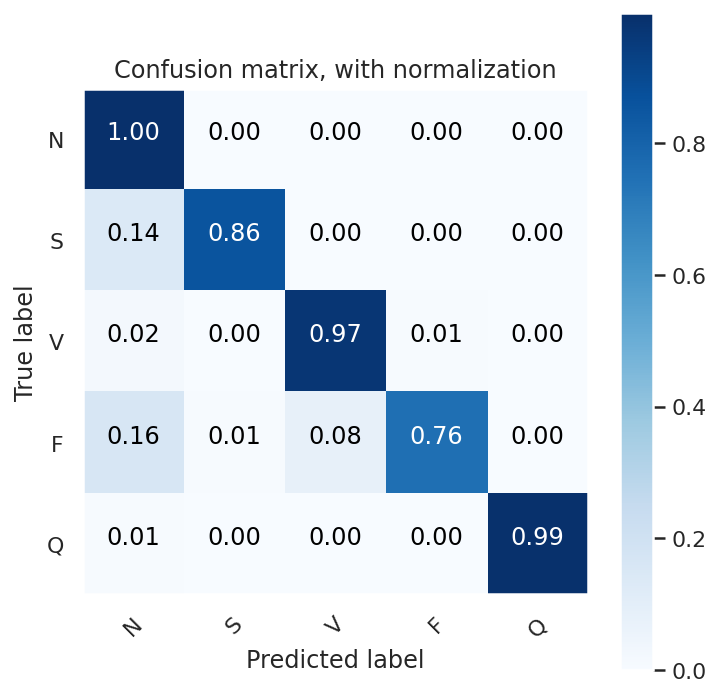

accuracy score =  0.9901162790697674
recall score =  0.9154178555156669
f1 score =  0.935743993928169
auc score =  0.9965425910626028
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22137
           1       0.95      0.86      0.90       692
           2       0.98      0.97      0.98      1797
           3       0.87      0.76      0.81       200
           4       1.00      0.99      1.00       974

    accuracy                           0.99     25800
   macro avg       0.96      0.92      0.94     25800
weighted avg       0.99      0.99      0.99     25800

[[1.00 0.00 0.00 0.00 0.00]
 [0.14 0.86 0.00 0.00 0.00]
 [0.02 0.00 0.97 0.01 0.00]
 [0.16 0.01 0.08 0.76 0.00]
 [0.01 0.00 0.00 0.00 0.99]]
pruned quantized tflite model accuracy = 0.9901
pruned quantized tflite model recall score = 0.9154
pruned quantized tflite model f1 score = 0.9357
pruned quantized tflite model auc score = 0.9965
Accuracy drop = 0.0007


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [125]:
# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quant_tflite_results = evaluate_tflite_model(quant_tflite_model)
print('pruned quantized tflite model accuracy = %.4f' % quant_tflite_results[0])
print('pruned quantized tflite model recall score = %.4f' % quant_tflite_results[1])
print('pruned quantized tflite model f1 score = %.4f' % quant_tflite_results[2])
print('pruned quantized tflite model auc score = %.4f' % quant_tflite_results[3])
print('Accuracy drop = %.4f' % (tflite_results[0] - quant_tflite_results[0]))

In [126]:
# Save the tflite model to file to the Downloads directory
f = open('./models/pqs_model.tflite', "wb")
f.write(quant_tflite_model)
f.close()

In [127]:
#Update Results
results_dict['model_name'].append('pqs tflite')
results_dict['no_par'].append(pqs_model.count_params())
results_dict['trn_t'].append('NA')
results_dict['trn_mem'].append('NA')
results_dict['trn_acc'].append('NA')
results_dict['tst_acc'].append(quant_tflite_results[0])
results_dict['recall_scr'].append(quant_tflite_results[1])
results_dict['f1_scr'].append(quant_tflite_results[2])
results_dict['auc_scr'].append(quant_tflite_results[3])
results_dict['cpu_inf_t'].append('TBD')
results_dict['cpu_thrpt'].append('TBD')
results_dict['gpu_inf_t'].append('NA')
results_dict['gpu_thrpt'].append('NA')
results_dict['model_size'].append(len(quant_tflite_model))
results_dict['gzipped_size'].append('NA')

In [128]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

In [129]:
results_df.columns = results_df.iloc[0] 

results_df = results_df[1:]

results_df

model_name,keras base model,keras base model,float32 tflite,float16 tflite,dynamic range tflite,full integer tflite,int8 tflite,pq keras model,pqs keras model,pqs tflite
no_par,14741,14741,14741,14741,14741,14741,14741,29092,29092,14741
trn_t,178.631,178.631,NA,NA,NA,NA,NA,284.737,284.737,NA
trn_mem,315904,315904,NA,NA,NA,NA,NA,726272,726272,NA
trn_acc,0.997093,0.997093,NA,NA,NA,NA,NA,0.996938,0.996938,NA
tst_acc,0.990814,0.990814,0.990814,0.990814,0.400388,0.990775,0.981163,0.990116,0.990116,0.990116
recall_scr,0.949175,0.949175,0.949175,0.949175,0.334964,0.943349,0.908592,0.915418,0.915418,0.915418
f1_scr,0.943398,0.943398,0.943398,0.943398,0.201483,0.941555,0.899979,0.935744,0.935744,0.935744
auc_scr,0.997414,0.997414,0.997429,0.997428,0.703738,0.986509,0.0298314,0.996543,0.996543,0.996543
cpu_inf_t,0.000160916,0.000160916,TBD,TBD,TBD,TBD,TBD,0.000320809,0.000320809,TBD
cpu_thrpt,6214.42,6214.42,TBD,TBD,TBD,TBD,TBD,3117.12,3117.12,TBD


In [130]:
file_path = '../../results'
file_name = ipynbname.name()
file = os.path.join(file_path,file_name)+'.csv'

results_df.to_csv(file,mode='w')